# Week 14 (Wednesday), AST 8581 / PHYS 8581 / CSCI 8581 / STAT 8581: Big Data in Astrophysics

### Michael Coughlin <cough052@umn.edu>

With contributions totally ripped off from Ulisses Braga-Neto (Texas A&M)



# Where are we headed?

Foundations of Data and Probability -> Statistical frameworks (Frequentist vs Bayesian) -> Estimating underlying distributions -> Analysis of Time series (periodicity) -> Analysis of Time series (variability) -> Analysis of Time series (stochastic processes) -> Gaussian Processes -> Decision Trees / Regression -> Dimensionality Reduction -> Principle Component Analysis -> Clustering -> Density Estimation / Anomaly Detection -> Supervised Learning -> Deep Learning -> Introduction to Databases - SQL -> Introduction to Databases - NoSQL ->  Introduction to GPUs --> More advanced GPU Algorithms -> Introduction to Multiprocessing -> Unit Testing -> Introduction to Citizen Science -> <b> Introduction to Physics Informed Machine Learning </b>

# Introduction to Physics Informed Machine Learning

The emerging field of physics-informed machine learning, also known as scientific machine learning, integrates data-driven approaches with physical theory to tackle complex problems in science and engineering. These algorithms incorporate strong prior knowledge—typically in the form of differential equations that describe relationships between variables—into the learning process. Unlike traditional numerical methods, they do not require complex meshing, yield differentiable solutions, and can easily assimilate data. This lecture provides a detailed overview of physics-informed neural networks and physics-informed Gaussian process regression, addressing both forward and inverse problems, and discussing the use of soft and hard constraints.



<img src="figures/piml.png" width=600>

### Physics-Informed Machine Learning (PIML)

A paradigm that integrates **scientific knowledge** — such as differential equations — directly into **machine learning models**.

We'll explore:
- What PIML is and why it's useful
- A simple example using a differential equation
- How to implement a Physics-Informed Neural Network (PINN)

### Traditional Scientific Computation vs. Physics-Informed Machine Learning

In traditional scientific computation, the inputs typically consist of variables such as position, time, angle, and frequency, while the outputs represent physical quantities like concentration, velocity, pressure, and temperature. When a complete theory of the physical phenomenon is available—usually expressed as a partial differential equation (PDE) along with initial and boundary conditions—there exists a well-established body of numerical methods to compute outputs from given inputs.

On the other hand, if no underlying theory is known but sufficient data in the form of input-output pairs is available, traditional machine learning methods can be employed to predict outputs based on inputs. However, this approach requires a large amount of labeled data that adequately covers the entire physical domain.

In practice, the assumptions required by either of these traditional approaches are rarely fully met. On the theoretical side, physical parameters may be unknown or only approximately known, and boundary conditions might be incomplete or missing. From the data perspective, acquiring labeled data can be expensive, and it may be infeasible to obtain complete coverage of the physical domain or all relevant output quantities.

Physics-informed machine learning (PIML) occupies the space between traditional scientific computation and conventional machine learning. PIML does not assume access to a complete theory or an abundance of data—but rather a sufficient amount of both. It is fundamentally a machine learning approach, but one that incorporates strong priors in the form of known physical laws.

Unlike traditional machine learning, PIML algorithms can extrapolate to regions with little or no data, thanks to their grounding in physical theory. Conversely, unlike traditional scientific computing, they can compensate for missing or incomplete physics by learning from data.

As of now, the two main classes of PIML methods are based on deep neural networks and Gaussian processes, both constrained by PDEs and initial/boundary conditions. These constraints can be imposed in a "soft" manner—where outputs approximately satisfy the physics—or "hard"—where outputs must satisfy the constraints exactly.


### What is Physics-Informed Machine Learning?

In traditional machine learning, models are trained purely from data.

However, in many physical systems:
- Data is **scarce or expensive** to obtain
- But we **know the physics**, often described by **differential equations**

**Physics-Informed ML** fuses these two sources:
- Data-driven learning + Physics-based constraints
- This leads to better generalization, stability, and performance with limited data

One popular PIML approach is the **Physics-Informed Neural Network (PINN)**, where the **loss function includes the physics** (e.g., a differential equation residual).


### Toy Problem: Solving a Simple ODE

Let’s solve the ODE:

$$
\frac{dy}{dx} = -y, \quad y(0) = 1
$$

The analytical solution is:

$$
y(x) = e^{-x}
$$

We'll train a neural network to learn this solution, but instead of using true values of `y`, we'll enforce the ODE in the loss function.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [ ]:
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        return self.net(x)
    
def pinn_loss(model, x):
    # Ensure x requires gradient
    x = x.clone().detach().requires_grad_(True)
    y = model(x)
    
    # Compute dy/dx using autograd
    dy_dx = torch.autograd.grad(
        y, x,
        grad_outputs=torch.ones_like(y),
        create_graph=True
    )[0]

    # ODE residual: dy/dx + y ≈ 0
    ode_residual = dy_dx + y
    loss_phys = torch.mean(ode_residual**2)

    # Initial condition y(0) = 1
    y0_pred = model(torch.tensor([[0.0]]))
    loss_ic = (y0_pred - 1.0)**2

    return loss_phys + loss_ic

model = SimpleNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training
for epoch in range(1000):
    optimizer.zero_grad()
    
    x_train = torch.linspace(0, 2, 100).view(-1, 1)
    loss = pinn_loss(model, x_train)
    
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")
        
        
# Compare with analytical solution
x_plot = torch.linspace(0, 2, 100).view(-1, 1)
y_pred = model(x_plot).detach().numpy()
y_true = np.exp(-x_plot.numpy())

plt.figure(figsize=(8,5))
plt.plot(x_plot, y_pred, label='PINN Prediction')
plt.plot(x_plot, y_true, label='Analytical Solution', linestyle='dashed')
plt.legend()
plt.title('Solution to dy/dx = -y using Physics-Informed NN')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

without seeing any actual solution data — it learned solely from the **physics**!

This approach can scale to:
- PDEs (e.g., Navier-Stokes, heat equation)
- Inverse problems (learning parameters)
- Real-world simulations where data is limited but physics is known

So let's do some PDEs.


# In-class warm-up: viscous Burgers nonlinear PDE

This block computes an accurate approximation to the solution of a viscous Burgers nonlinear PDE with a sinusoidal initial condition and homogeneous Dirichlet boundary conditions

  \begin{aligned}
  &u_t + uu_x = \nu u_{xx}\,, \quad (x,t) \in [-1,1] \times [0,\infty)\,,\\
    & u(x,0) = -\sin(\pi x)\,, \quad -1 < x < 1\,, \quad\quad\quad\quad  (1)\\
    &u(1,t) = u(-1,t) = 0\,, \quad t>0\,,\\
  \end{aligned}

where $\nu>0$ is the kinematic viscosity (The inverse of the viscosity $R=1/\nu$ is the Reynolds number for this problem.)

If the viscosity is smaller than about $0.1\pi$, the solution of (1) has a hyperbolic character, and a "shock" forms at $x=0$ (this is not a real shock, due to the diffusion term). Otherwise, there is not enough energy in the initial condition to overcome the viscosity, and the solution has a diffusive character.

For comparison, an accurate approximation of the solution is computed by Gauss-Hermite quadrature, based on a program by John Burkardt (https://people.sc.fsu.edu/~jburkardt/py_src/burgers_solution/burgers_solution.py).

The quadrature approximation is based on the fact that, for large enough $R$, (1) is an approximation of the inviscid Burgers problem ($\nu = 0$), in which case it can be proved using the method of characteristics that any zero value in the initial condition stays constant at zero throughout the solution. Therefore, (1) is approximately equal to the initial-value problem (IVP):
\begin{aligned}
  &\hat{u}_t + \hat{u}\hat{u}_x = \nu \hat{u}_{xx}\,, \quad (x,t) \in R \times [0,\infty)\,,\\
    & \hat{u}(x,0) = \begin{cases} -\sin(\pi x)\,,& -1 < x < 1\,,\\
    0\,, & |x|>1\,. \end{cases} \quad\quad\quad\quad  (2)\\
  \end{aligned}
The Cole-Hopf transform [1] provides a closed-form solution to the IVP (2):

$$\hat{u}(x,t) = -\frac{\int_{-\infty}^\infty \sin(\pi(x-z))\exp\left(-\frac{\cos(\pi(x-z))}{2\pi \nu}\right)\exp\left(-\frac{z^2}{4\nu t}\right)\, dz}
{\int_{-\infty}^\infty \exp\left(-\frac{\cos(\pi(x-z))}{2\pi \nu}\right)\exp\left(-\frac{z^2}{4\nu t}\right)\, dz}\,.$$

For sufficiently small $t$, we have $u(x,t) \approx \hat{u}(x,t)$, for $x \in [-1,1]$. In [2], it is claimed that Gauss-Hermite quadrature produced a seven-digit accurate result for $u_x(0,t)$ up to $t = 3/\pi$ with a viscosity $\nu = 0.01/\pi$.

References:

[1]  E. Hopf, The partial differential equation $u_t + uu_x = \mu u_{xx}$. Comm. Pure Appl. Math. 3, 201-230, 1950.

[2] Claude Basdevant, Michel Deville, Pierre Haldenwang, J Lacroix,
  J Ouazzani, Roger Peyret, Paolo Orlandi, Anthony Patera,
  Spectral and finite difference solutions of the Burgers equation,
  Computers and Fluids,   Volume 14, Number 1, 1986, pages 23-41.

In [ ]:
"""
Problem Definition and Quadrature Solution
"""

import numpy as np
from numpy.polynomial.hermite import hermgauss

nu = 0.01/np.pi # viscosity parameter

# define grid for quadrature solution
utn = 100
uxn = 256
xlo = -1.0
xhi = +1.0
ux = np.linspace(xlo,xhi,uxn)
tlo = 0.0
thi = 1.0
ut = np.linspace (tlo,thi,utn)

qn = 32 # order of quadrature rule
qx,qw = hermgauss(qn)

# compute solution u(x,t) by quadrature of analytical formula:
u_quad = np.zeros([uxn,utn])
for utj in range(utn):
  if (ut[utj]==0.0):
    for uxj in range(uxn):
      u_quad[uxj,utj] = -np.sin(np.pi*ux[uxj])
  else:
    for uxj in range(uxn):
      top = 0.0
      bot = 0.0
      for qj in range(qn):
        c = 2.0*np.sqrt(nu*ut[utj])
        top = top-qw[qj]*c*np.sin(np.pi*(ux[uxj]-c*qx[qj]))*np.exp(-np.cos(np.pi*(ux[uxj]-c*qx[qj]))/(2.0*np.pi*nu))
        bot = bot+qw[qj]*c*np.exp(-np.cos(np.pi*(ux[uxj]-c*qx[qj]))/(2.0*np.pi*nu))
        u_quad[uxj,utj] = top/bot

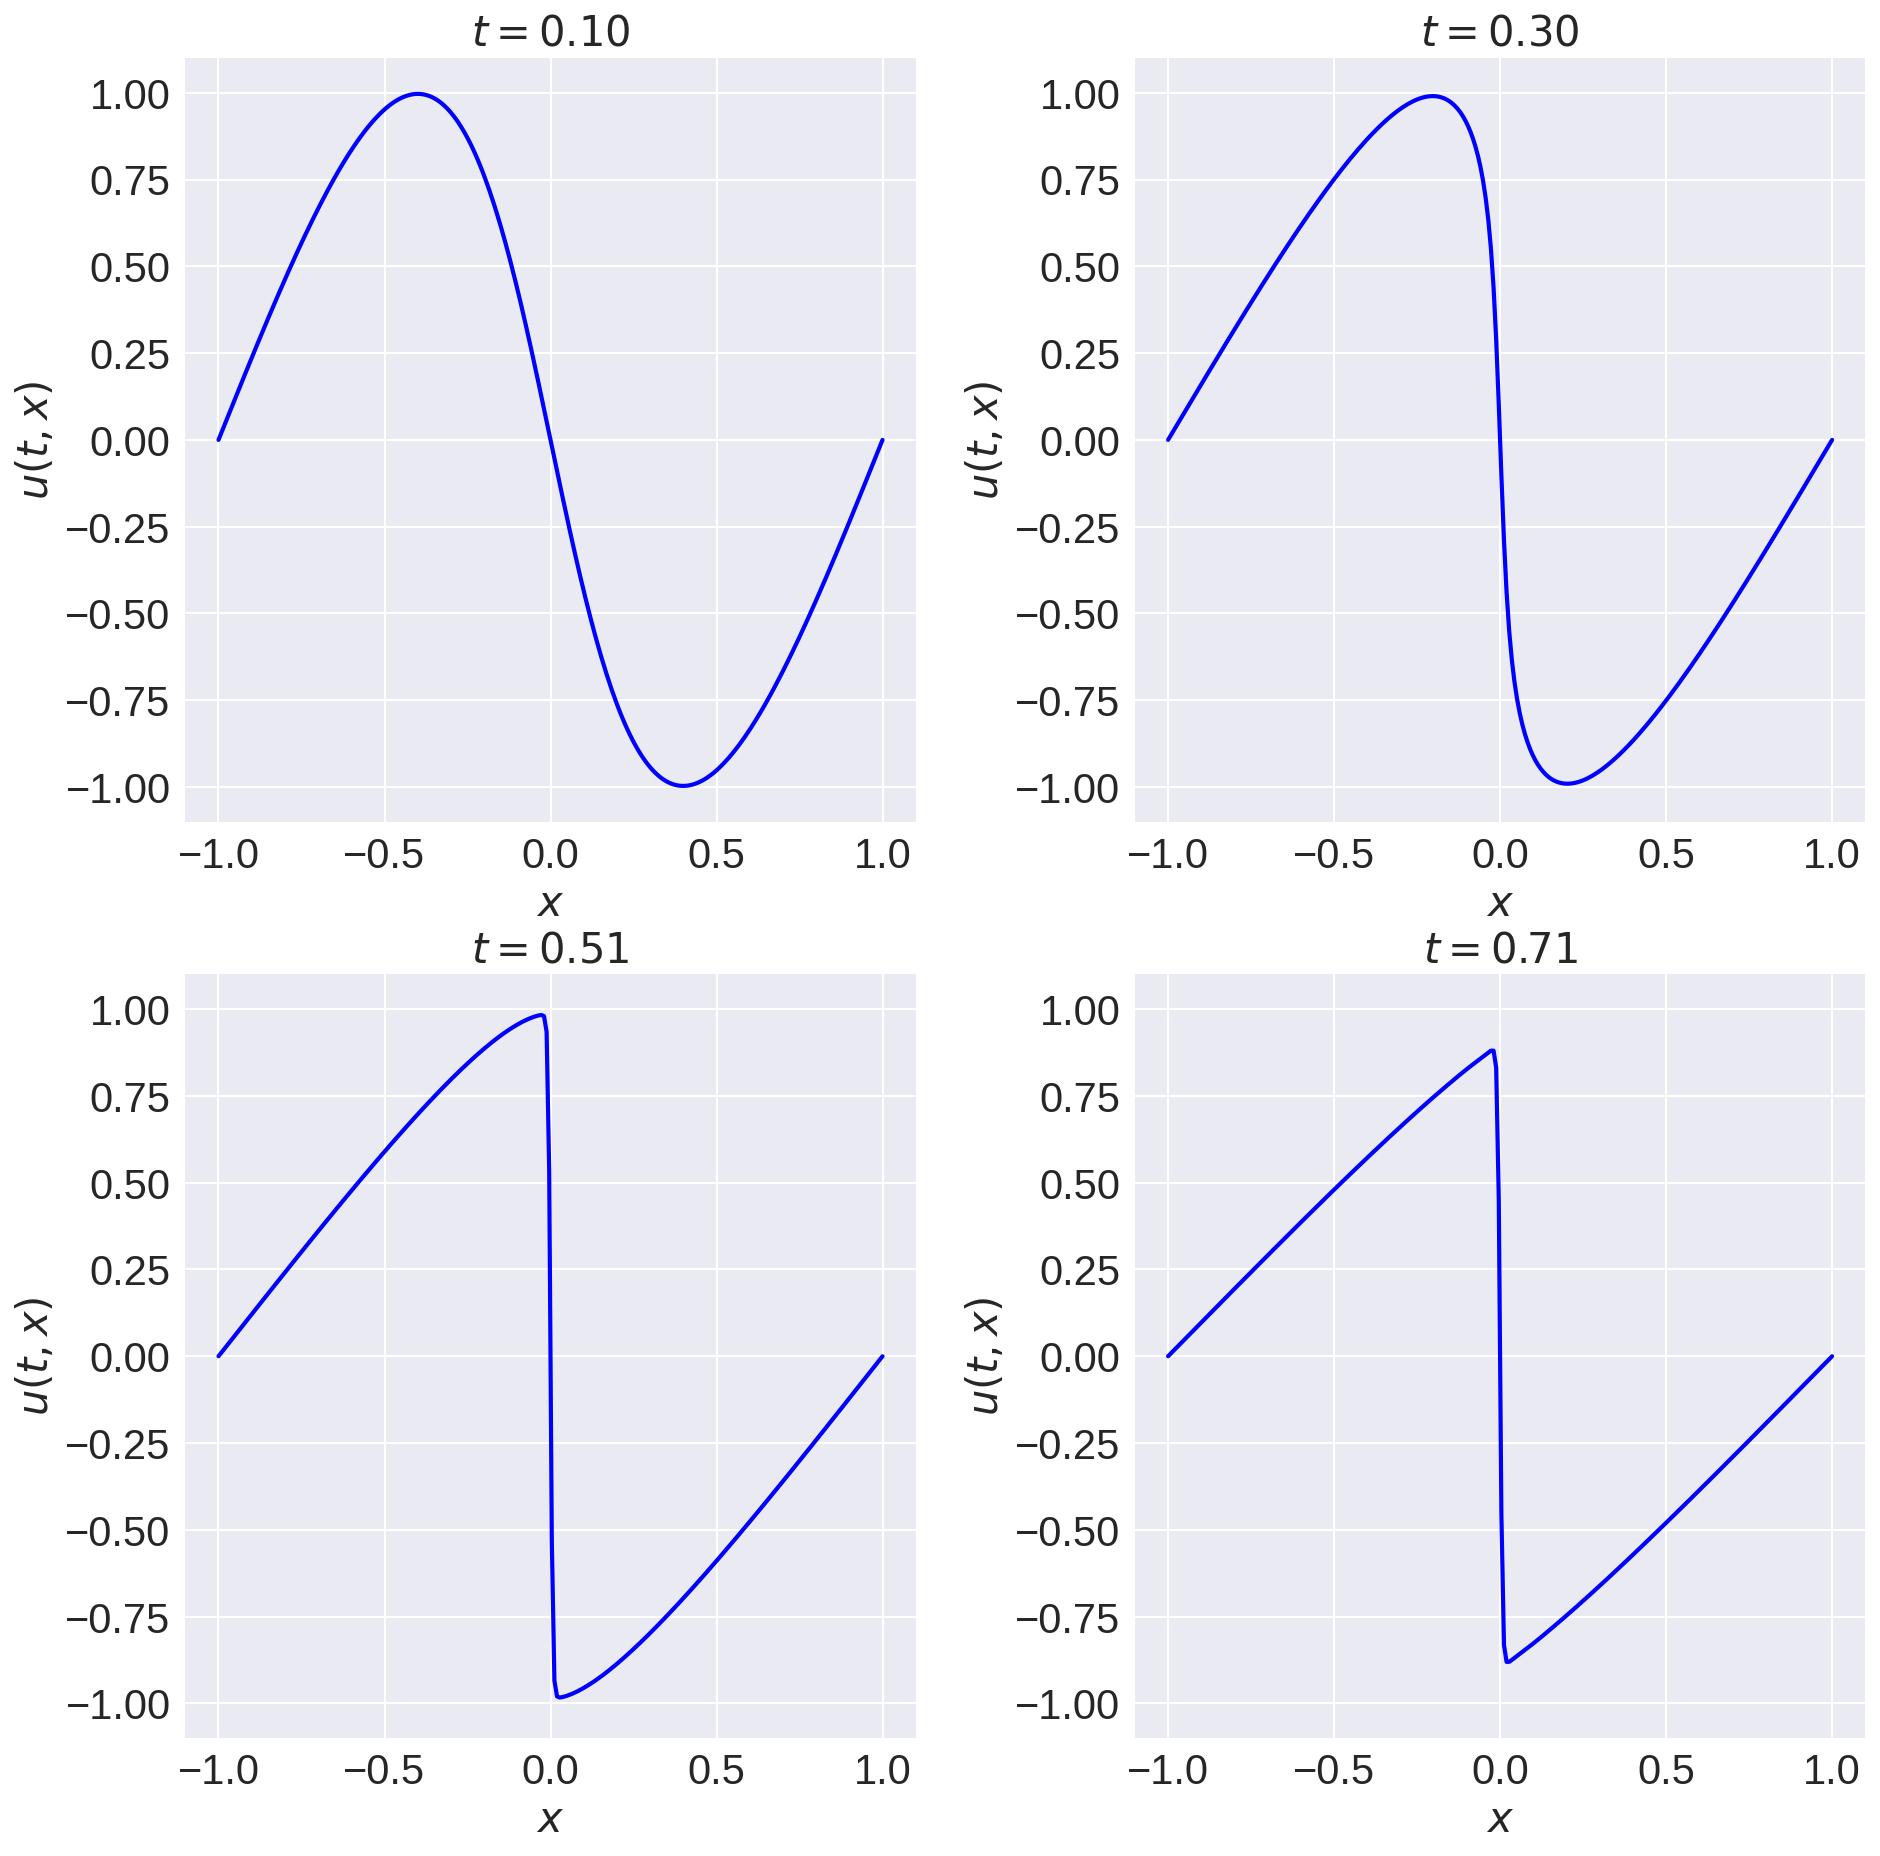

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
"""
Display results
"""

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from google.colab import files

plt.style.use('seaborn-v0_8-white')
fig = plt.figure(figsize=(8,8),dpi=150)
gs = gridspec.GridSpec(1,1)
gs.update(top=1,bottom=0,left=0,right=1,wspace=0.25)
ax = plt.subplot(gs[0,0])
im=ax.imshow(u_quad,interpolation='nearest',cmap='seismic',extent=[0.0,1.0,-1.0,1.0],origin='lower',aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar=fig.colorbar(im,cax=cax)
cbar.ax.tick_params(labelsize=14)
ax.tick_params(axis='both',which='major',labelsize=18)
ax.set_xlabel('$t$',fontsize=20)
ax.set_ylabel('$x$',fontsize=20)
ax.set_title('$u(t,x)$',fontsize=20)
fig.savefig('Fig-Burgers_a.png',bbox_inches="tight",facecolor="white")

slices = [0.1,0.3,0.5,0.7]
plt.style.use('seaborn-v0_8')
fig = plt.figure(figsize=(8,8),dpi=150)
gs = gridspec.GridSpec(2,2)
gs.update(top=1.4,bottom=0,left=0,right=1.4,wspace=0.3)
for gi,snap in enumerate(slices):
    tind = int(snap*len(ut))
    ax = plt.subplot(gs[gi])
    ax.plot(ux,u_quad[:,tind],'b-',linewidth=2)
    ax.set_title('$t = %.2f$' % (ut[tind]),fontsize=20)
    ax.set_xlabel('$x$',fontsize=20)
    ax.set_ylabel('$u(t,x)$',fontsize=20)
    ax.tick_params(axis='both',which='major',labelsize=20)
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])
plt.show()
fig.savefig('Fig-Burgers_b.png',bbox_inches="tight",facecolor="white")

files.download('Fig-Burgers_a.png')
files.download('Fig-Burgers_b.png')

## In-class exercise: viscous Burgers nonlinear PDE

This python script demonstrates coding and training a physics-informed neural networks (PINN) to solve the viscous Burgers nonlinear PDE with a sinusoidal initial condition and homogeneous Dirichlet boundary conditions:

  \begin{aligned}
  &u_t + uu_x = \nu u_{xx}\,, \quad (x,t) \in [-1,1] \times [0,\infty)\,,\\
    & u(x,0) = -\sin(\pi x)\,, \quad -1 < x < 1\,, \\
    &u(1,t) = u(-1,t) = 0\,, \quad t>0\,,\\
  \end{aligned}

where $\nu>0$ is the kinematic viscosity. If the viscosity is smaller than about $0.1\pi$, the solution of (1) has a hyperbolic character, and a "shock" forms at $x=0$(this is not a real shock, due to the diffusion term).The PINN solution is compared to the same accurate approximation of the solution used in c12_Burgers.ipynb.

In [1]:
"""
Import libraries
"""

import tensorflow as tf
import numpy as np
import scipy.io
import math
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import layers, activations
import matplotlib.pyplot as plt
from scipy.stats.qmc import LatinHypercube as lhs
tf.keras.backend.set_floatx('float32')

In [2]:
"""
Problem Definition and Quadrature Solution
"""

import numpy as np
from numpy.polynomial.hermite import hermgauss

# Fix random state for reproducibility
#np.random.seed(1968881)

nu = 0.01/np.pi # viscosity parameter

# define grid for quadrature solution
# this will also be the test grid for the PINN
utn = 100
uxn = 256
xlo = -1.0
xhi = +1.0
ux = np.linspace(xlo,xhi,uxn)
tlo = 0.0
thi = 1.0
ut = np.linspace (tlo,thi,utn)

qn = 32 # order of quadrature rule
qx,qw = hermgauss(qn)

# compute solution u(x,t) by quadrature of analytical formula:
u_quad = np.zeros([uxn,utn])
for utj in range(utn):
  if (ut[utj]==0.0):
    for uxj in range(uxn):
      u_quad[uxj,utj] = -np.sin(np.pi*ux[uxj])
  else:
    for uxj in range(uxn):
      top = 0.0
      bot = 0.0
      for qj in range(qn):
        c = 2.0*np.sqrt(nu*ut[utj])
        top = top-qw[qj]*c*np.sin(np.pi*(ux[uxj]-c*qx[qj]))*np.exp(-np.cos(np.pi*(ux[uxj]-c*qx[qj]))/(2.0*np.pi*nu))
        bot = bot+qw[qj]*c*np.exp(-np.cos(np.pi*(ux[uxj]-c*qx[qj]))/(2.0*np.pi*nu))
        u_quad[uxj,utj] = top/bot

# flatten grid and solution
X,T = np.meshgrid(ux,ut)
X_flat = tf.convert_to_tensor(np.hstack((X.flatten()[:,None],T.flatten()[:,None])),dtype=tf.float32)
u_flat = u_quad.T.flatten()

In [38]:
# solution neural network

layer_sizes = [2] + 8*[20] + [1]

def neural_net(layer_sizes):
    model = Sequential()
    model.add(layers.InputLayer(input_shape=(layer_sizes[0],)))
    for width in layer_sizes[1:-1]:
        model.add(layers.Dense(
            width, activation=tf.nn.tanh,
            kernel_initializer="glorot_normal"))
    model.add(layers.Dense(
            layer_sizes[-1], activation=None,
            kernel_initializer="glorot_normal"))
    return model

u_PINN = neural_net(layer_sizes)

In [39]:
# residual neural network

@tf.function
def r_PINN(x,t):
    u    = u_PINN(tf.concat([x,t], 1))
    u_x  = tf.gradients(u,x)[0]
    u_xx = tf.gradients(u_x, x)[0]
    u_t  = tf.gradients(u,t)[0]
    return u_t + u*u_x - (0.01/np.pi)*u_xx

In [40]:
# PINN loss function

def loss(xcl,tcl,x0,t0,u0,xlb,tlb,ulb,xub,tub,uub):
    u0_pred  = u_PINN(tf.concat([x0,t0],1))
    ulb_pred = u_PINN(tf.concat([xlb,tlb],1))
    uub_pred = u_PINN(tf.concat([xub,tub],1))
    r_pred   = r_PINN(xcl,tcl)

    # loss components
    mse_0  = tf.reduce_mean(tf.pow(u0-u0_pred,2))
    mse_lb = tf.reduce_mean(tf.pow(ulb_pred-ulb,2))
    mse_ub = tf.reduce_mean(tf.pow(uub_pred-uub,2))
    mse_r  = tf.reduce_mean(tf.pow(r_pred,2))

    return  mse_0+mse_r+mse_lb+mse_ub

In [41]:
# neural network weight gradients
@tf.function
def grad(model,xcl,tcl,x0,t0,u0,xlb,tlb,ulb,xub,tub,uub):
    with tf.GradientTape(persistent=True) as tape:
        loss_value = loss(xcl,tcl,x0,t0,u0,xlb,tlb,ulb,xub,tub,uub)
        grads = tape.gradient(loss_value,model.trainable_variables)
    return loss_value, grads

In [42]:
# collocation points
Ncl = 10000
X = lhs(2).random(Ncl)
xcl = tf.expand_dims(tf.convert_to_tensor(xlo+(xhi-xlo)*X[:,0],dtype=tf.float32),-1)
tcl = tf.expand_dims(tf.convert_to_tensor(tlo+(thi-tlo)*X[:,1],dtype=tf.float32),-1)

# initial condition points
N0 = 200
x0 = tf.expand_dims(tf.convert_to_tensor(ux,dtype=tf.float32),-1)
t0 = tf.zeros(tf.shape(x0),dtype=tf.float32)
u0 = -tf.math.sin(np.pi*x0)

# Dirichlet boundary condition points
Nb = 100
xlb = tf.expand_dims(xlo*tf.ones(tf.shape(ut),dtype=tf.float32),-1)
tlb = tf.expand_dims(tf.convert_to_tensor(ut,dtype=tf.float32),-1)
ulb = tf.expand_dims(tf.zeros(tf.shape(ut),dtype=tf.float32),-1)
xub = tf.expand_dims(xhi*tf.ones(tf.shape(ut),dtype=tf.float32),-1)
tub = tf.expand_dims(tf.convert_to_tensor(ut,dtype=tf.float32),-1)
uub = tf.expand_dims(tf.zeros(tf.shape(ut),dtype=tf.float32),-1)

iter =  100
loss = 2.5399e-01
L2 error: 6.2142e-01


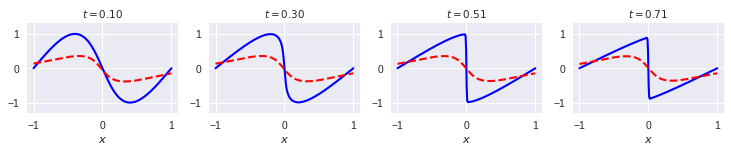

iter =  200
loss = 1.6984e-01
L2 error: 5.1826e-01


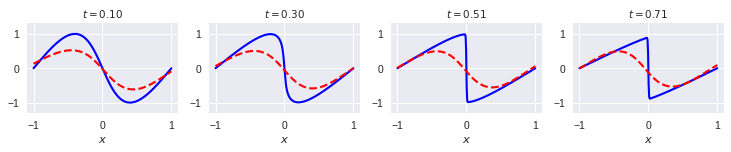

iter =  300
loss = 1.4655e-01
L2 error: 5.4177e-01


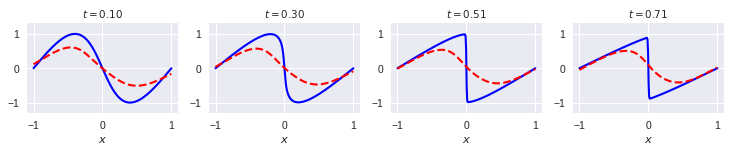

iter =  400
loss = 1.2704e-01
L2 error: 4.8415e-01


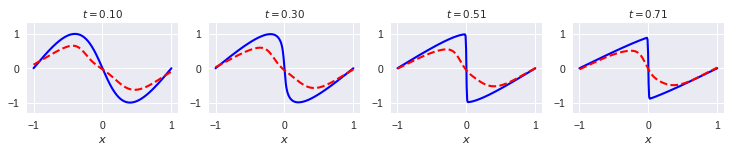

iter =  500
loss = 1.1120e-01
L2 error: 4.6392e-01


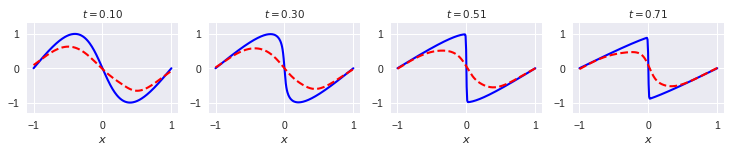

iter =  600
loss = 9.8310e-02
L2 error: 4.3280e-01


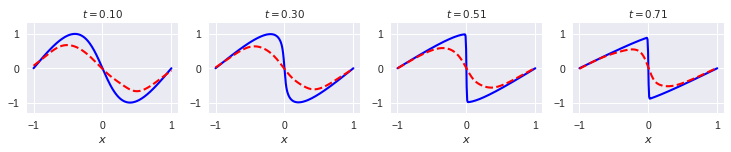

iter =  700
loss = 8.8006e-02
L2 error: 4.1408e-01


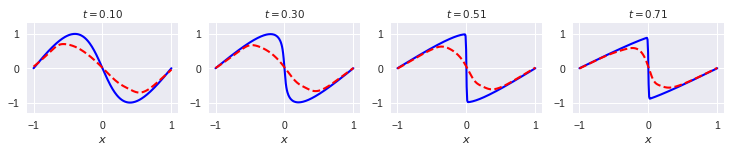

iter =  800
loss = 7.6822e-02
L2 error: 3.9177e-01


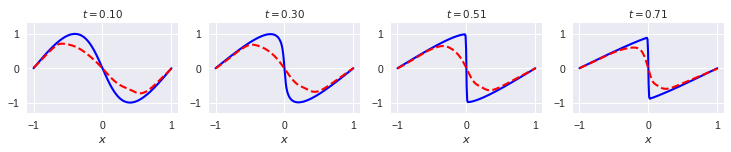

iter =  900
loss = 5.5558e-02
L2 error: 3.0285e-01


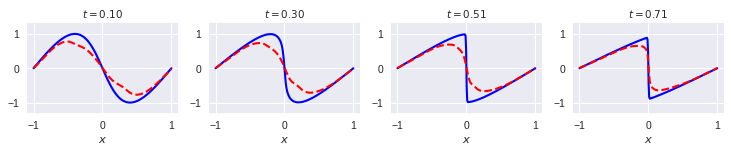

iter =  1000
loss = 3.4622e-02
L2 error: 2.0328e-01


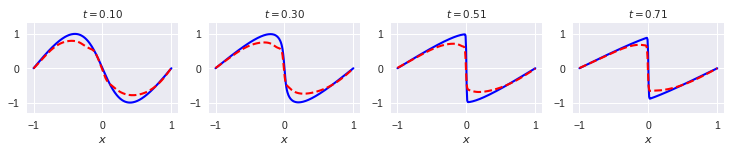

iter =  1100
loss = 1.6483e-02
L2 error: 1.7113e-01


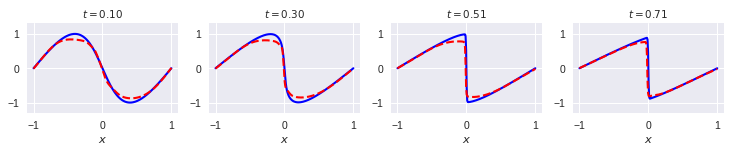

iter =  1200
loss = 6.5216e-03
L2 error: 1.3180e-01


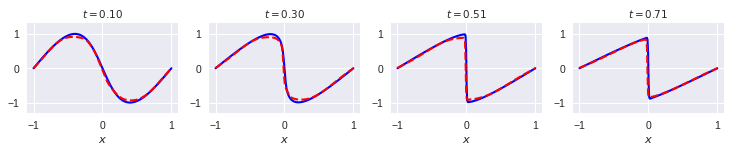

iter =  1300
loss = 3.9042e-03
L2 error: 7.8948e-02


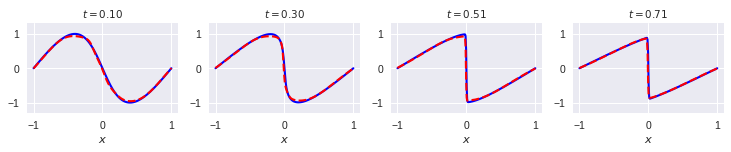

iter =  1400
loss = 2.0212e-03
L2 error: 9.7365e-02


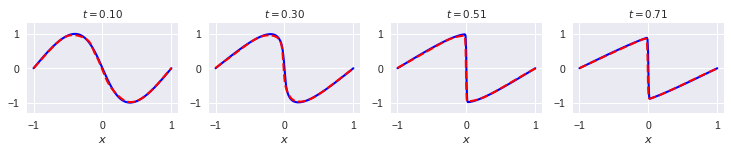

iter =  1500
loss = 1.2600e-03
L2 error: 8.5547e-02


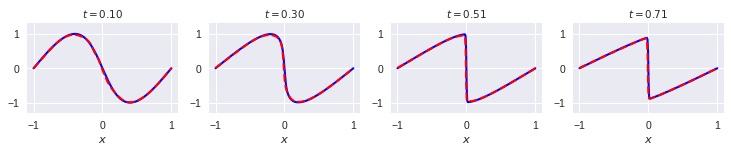

iter =  1600
loss = 8.3083e-04
L2 error: 3.0078e-02


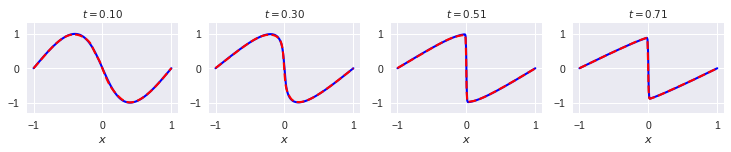

iter =  1700
loss = 6.3790e-04
L2 error: 3.1270e-02


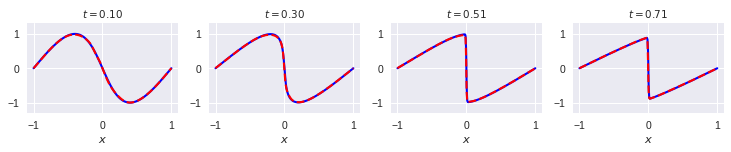

iter =  1800
loss = 4.9506e-04
L2 error: 3.4761e-02


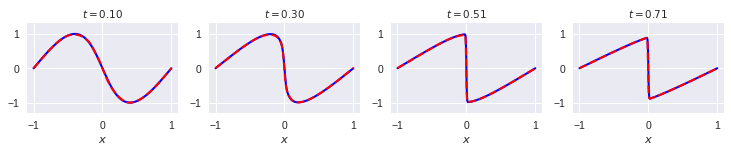

iter =  1900
loss = 4.2400e-04
L2 error: 3.4458e-02


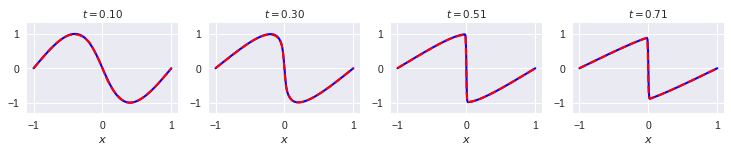

iter =  2000
loss = 3.9193e-04
L2 error: 3.4368e-02


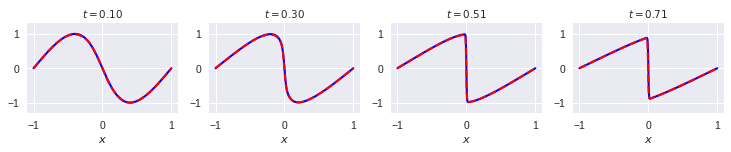

In [43]:
# training loop

# Adam optimizer
tf_optimizer = tf.keras.optimizers.Adam(learning_rate=0.003,beta_1=0.99)

N_iter = 2000
Dsp_step = 100

up_hist = np.zeros([utn*uxn,int(N_iter/Dsp_step)+1])
loss_hist = np.zeros([N_iter])
L2_hist = np.zeros([N_iter])
c = 0
for iter in range(N_iter):

  # compute gradients using AD
  loss_value,grads = grad(u_PINN,xcl,tcl,x0,t0,u0,xlb,tlb,ulb,xub,tub,uub)

  # update neural network weights
  tf_optimizer.apply_gradients(zip(grads,u_PINN.trainable_variables))

  # prediction and errors
  u_PINN_flat = u_PINN(X_flat)
  err = np.linalg.norm(u_flat-u_PINN_flat[:,-1],2)/np.linalg.norm(u_flat,2)
  loss_hist[iter] = loss_value
  L2_hist[iter] = err

  # store and display predictions
  if ((iter+1) % Dsp_step == 0):
    up_hist[:,c:(c+1)] = u_PINN_flat
    c += 1
    print('iter =  '+str(iter+1))
    print('loss = %.4e' % (loss_value))
    print('L2 error: %.4e' % (err))
    fig = plt.figure(figsize=(12,4),dpi=75)
    plt.style.use('seaborn-v0_8')
    for gi,snap in enumerate([0.1,0.3,0.5,0.7]):
      tind = int(snap*len(ut))
      ax = fig.add_subplot(1,4,gi+1)
      ax.set_aspect(0.5)
      ax.plot(ux,u_flat[tind*uxn:(tind+1)*uxn],'b-',linewidth=2,label='Exact')
      ax.plot(ux,u_PINN_flat[tind*uxn:(tind+1)*uxn,0],'r--',linewidth=2,label='Prediction')
      ax.set_title('$t = %.2f$' % (ut[tind]),fontsize=10)
      ax.set_xlabel('$x$')
      ax.set_ylim([-1.3,1.3])
    plt.show()

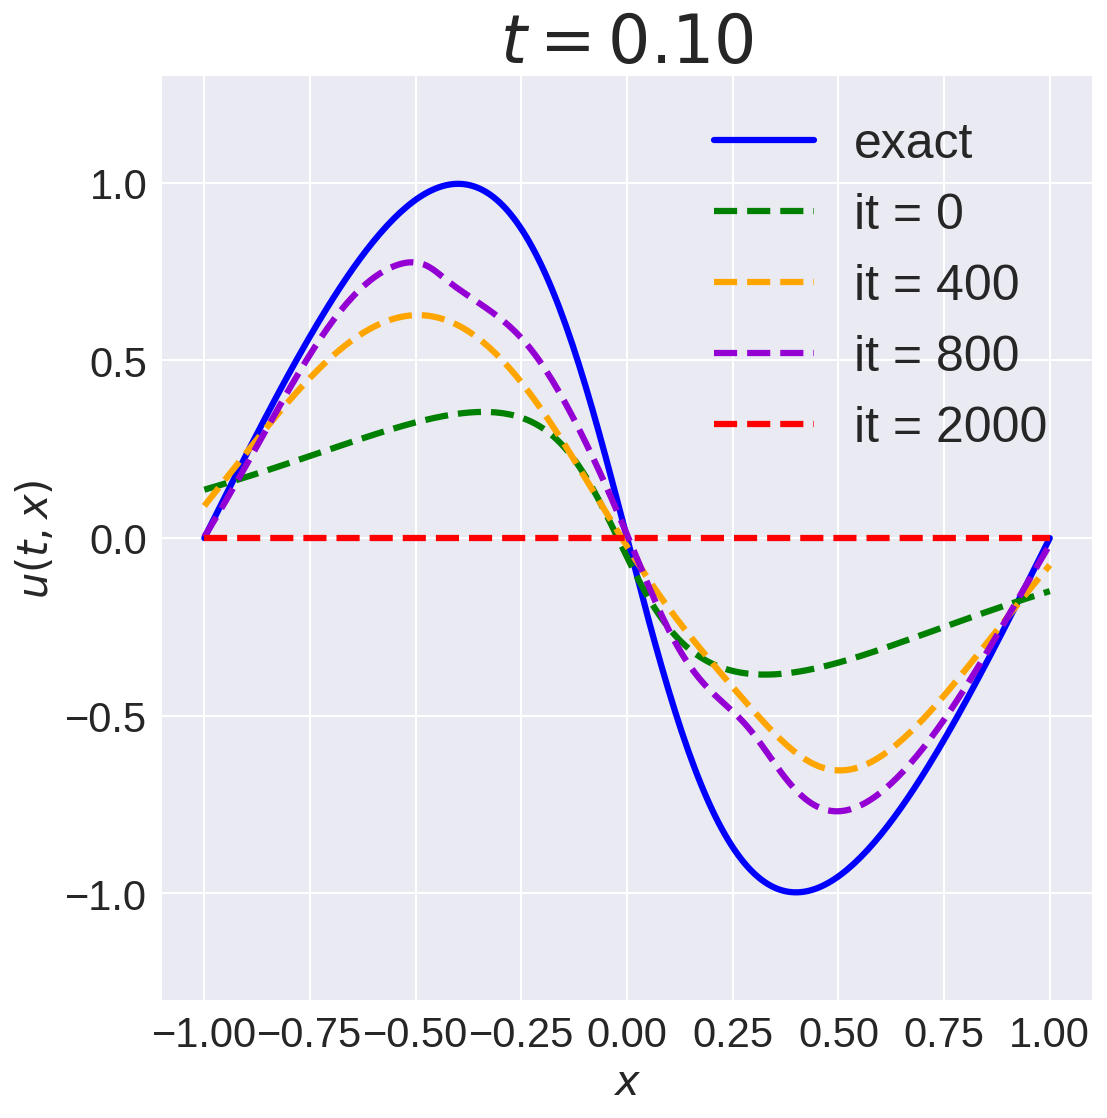

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

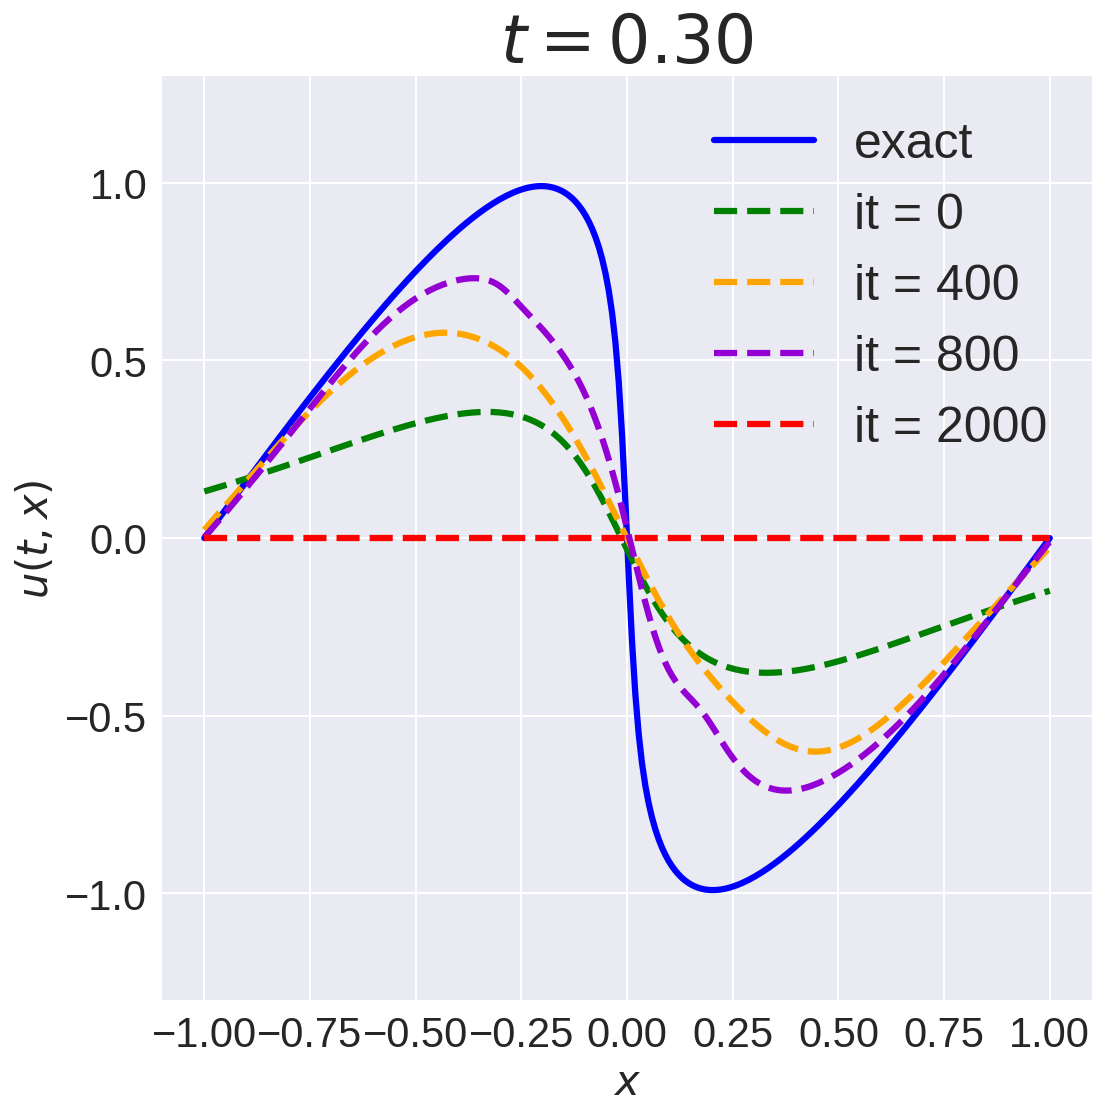

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

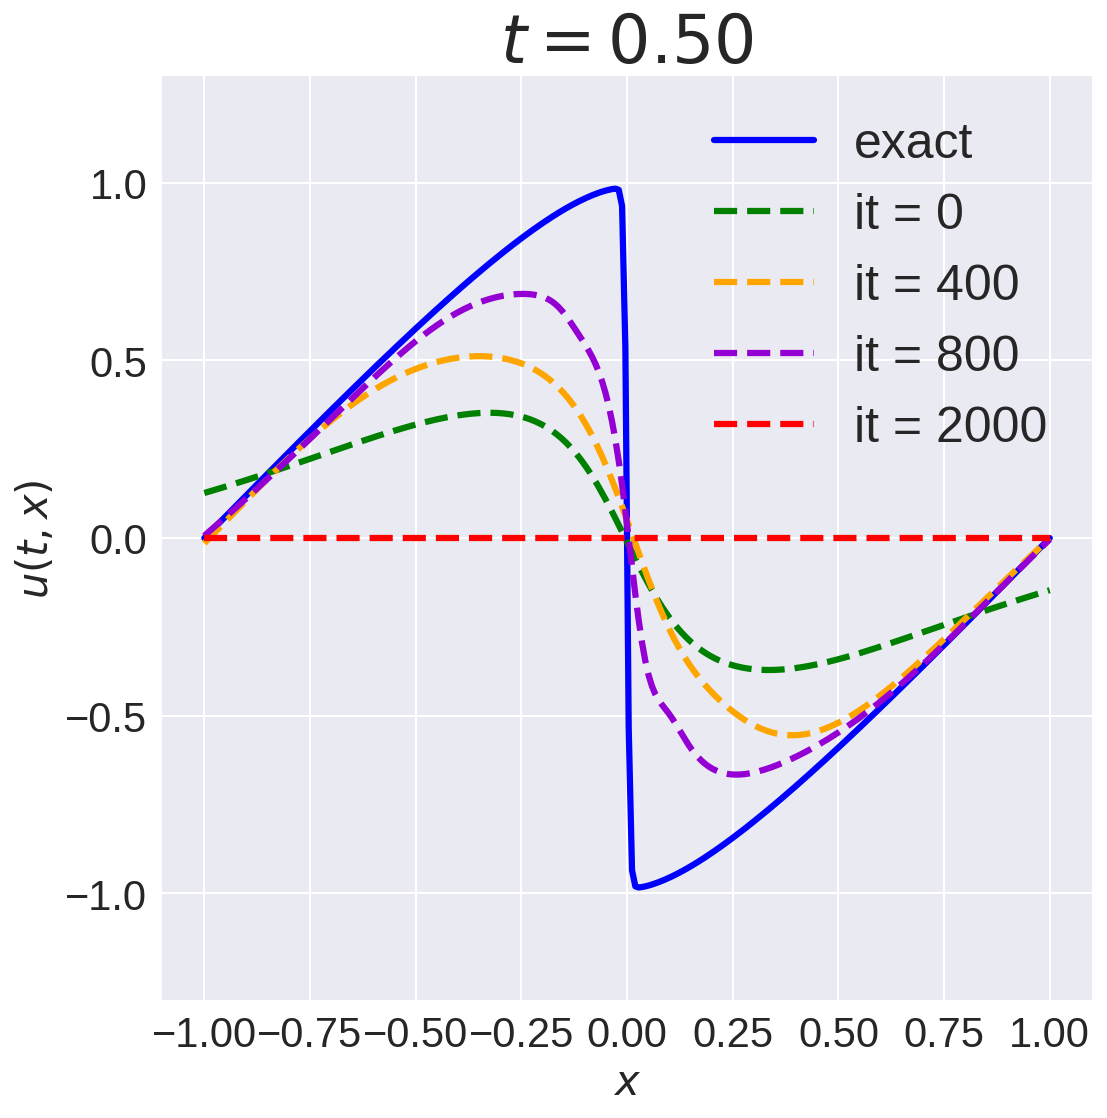

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

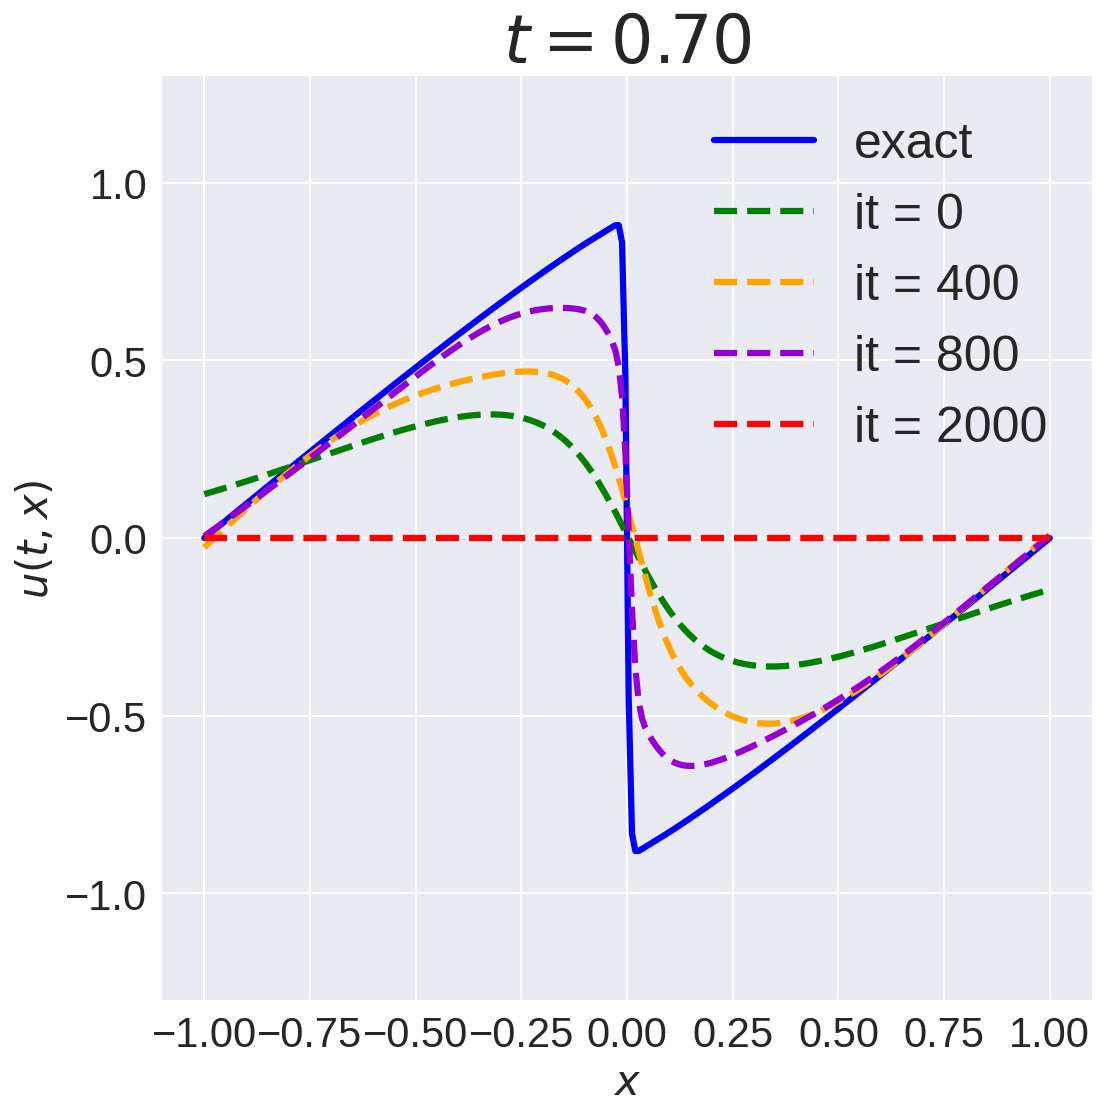

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

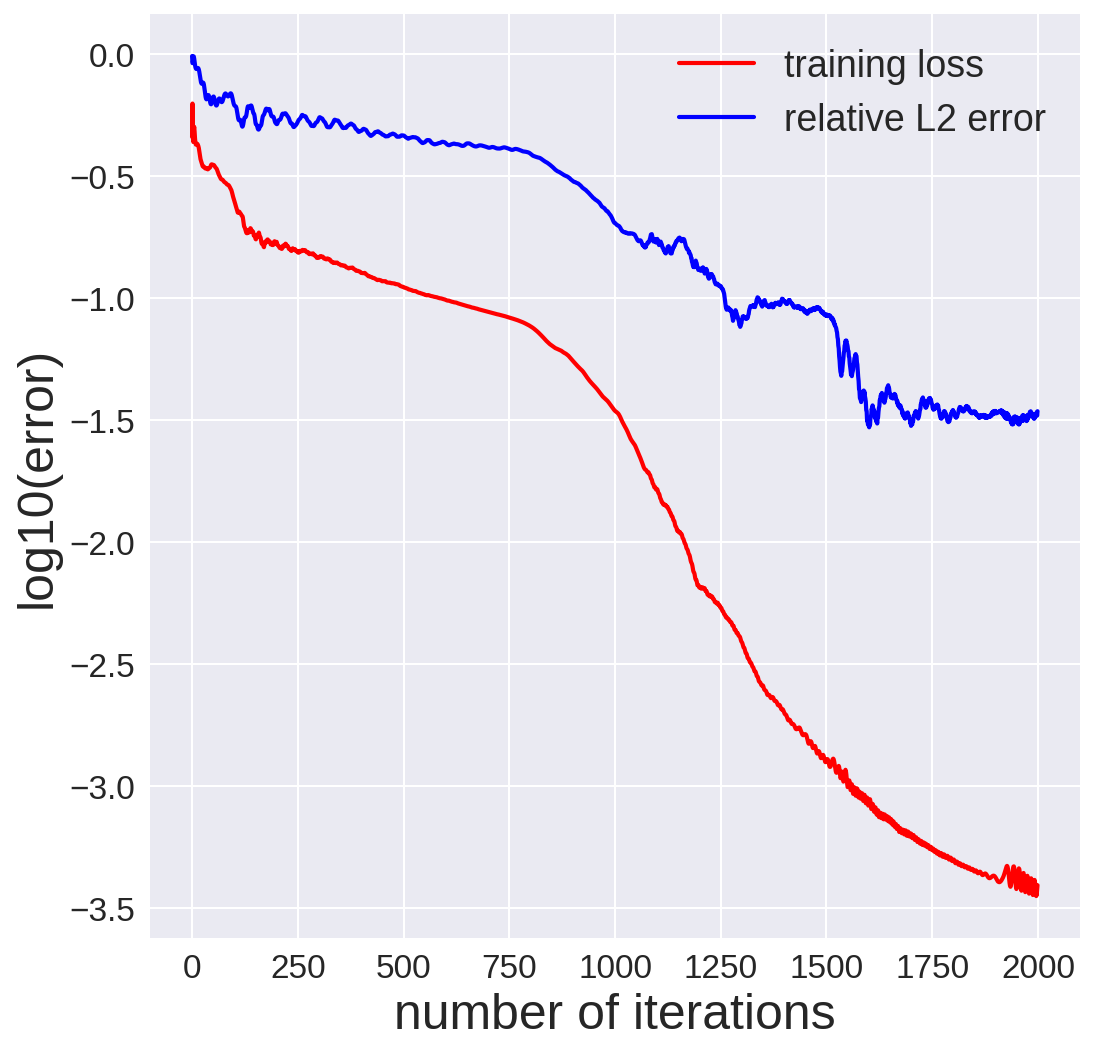

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<ipython-input-47-572c2f3735df>:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['-1.0','-0.6','-0.2','0.2','0.6','1.0'])


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

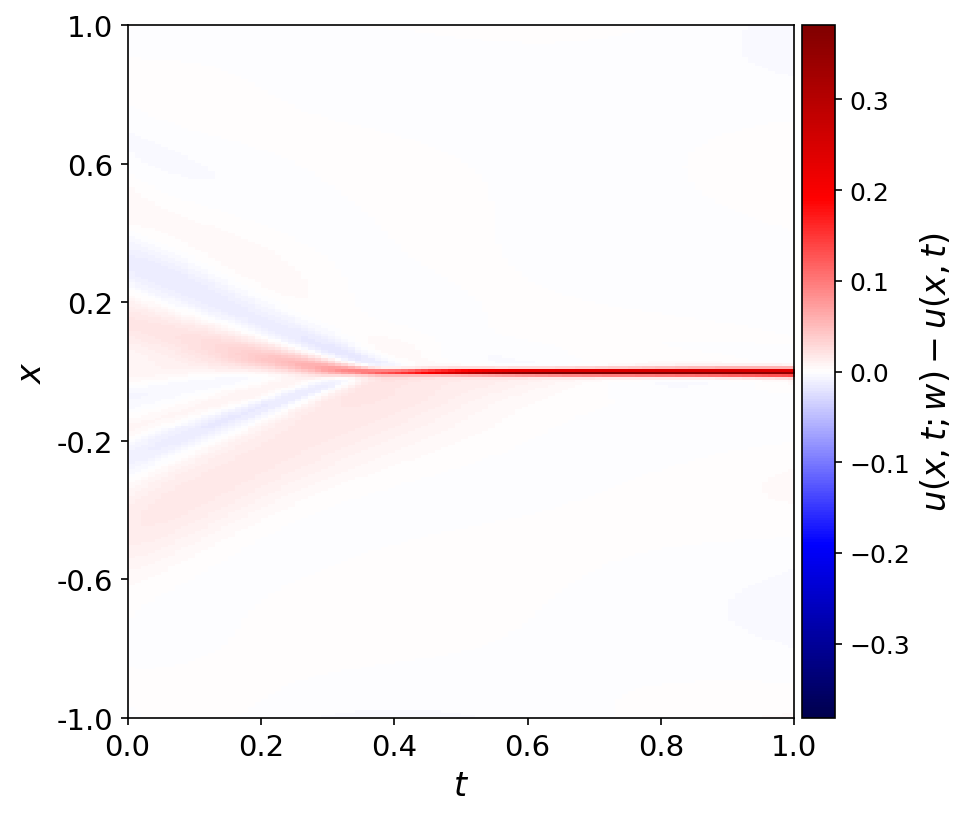

In [47]:
#Display results

from mpl_toolkits.axes_grid1 import make_axes_locatable
from google.colab import files

# solutions
cc = np.array(['green','orange','darkviolet','red'])
plt.style.use('seaborn-v0_8')
for snap in [0.1,0.3,0.5,0.7]:
      tind = int(snap*len(ut))
      fig = plt.figure(figsize=(8,8),dpi=150)
      plt.plot(ux,u_flat[tind*uxn:(tind+1)*uxn],'b-',linewidth=3,label='exact')
      for itc,it in enumerate([0,4,8,20]):
        plt.plot(ux,up_hist[tind*uxn:(tind+1)*uxn,it],color=cc[itc],linestyle='dashed',linewidth=3,label='it = '+str(Dsp_step*it))
      plt.title('$t = %.2f$' % (snap),fontsize=32)
      plt.xlabel('$x$',fontsize=20)
      plt.ylabel('$u(t,x)$',fontsize=20)
      plt.xticks(fontsize=20)
      plt.yticks(fontsize=20)
      plt.ylim([-1.3,1.3])
      plt.legend(fontsize=24,facecolor='white')
      plt.show()
      fig.savefig('Fig-BurgersPINN_t'+str(snap)+'.png',bbox_inches="tight",facecolor="white")
      files.download('Fig-BurgersPINN_t'+str(snap)+'.png')

# error plot
plt.style.use('seaborn-v0_8')
fig = plt.figure(figsize=(8,8),dpi=150)
plt.plot(np.arange(N_iter),np.log10(loss_hist),'r-',linewidth=2,label='training loss')
plt.plot(np.arange(N_iter),np.log10(L2_hist),'b-',linewidth=2,label='relative L2 error')
plt.xlabel('number of iterations',fontsize=24)
plt.ylabel('log10(error)',fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=18,facecolor='white')
plt.show()
fig.savefig('Fig-BurgersPINN_err.png',bbox_inches="tight",facecolor="white")
files.download('Fig-BurgersPINN_err.png')

# difference plot
plt.style.use('seaborn-v0_8')
fig = plt.figure(figsize=(14,6),dpi=150)
fig.subplots_adjust(wspace=0.3)
plt.style.use('default')
ax = fig.add_subplot(121)
ax.set_aspect(1)
diff = np.reshape(u_flat[:,np.newaxis]-u_PINN_flat,(utn,uxn)).T
rng = np.max([np.abs(np.max(diff)),np.abs(np.min(diff))])
im=ax.imshow(diff,interpolation='nearest',cmap='seismic',vmin=-rng,vmax=rng,extent=[0.0,1.0,0.0,1.0],origin='lower',aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right",size="5%",pad=0.05)
cax.tick_params(axis='both',which='major',labelsize=12)
cb = fig.colorbar(im,cax=cax)
cb.set_label(label='$u(x,t;w) - u(x,t)$',size=16)
ax.set_yticklabels(['-1.0','-0.6','-0.2','0.2','0.6','1.0'])
ax.set_xlabel('$t$',fontsize=16)
ax.set_ylabel('$x$',fontsize=16)
ax.tick_params(axis='both',which='major',labelsize=14)
fig.savefig('Fig-BurgersPINN_diff.png',bbox_inches="tight",facecolor="white")
files.download('Fig-BurgersPINN_diff.png')

(a) Modify the code above to change the viscosity in the range
$\nu$ = 0.1/$\pi$, 0.03/$\pi$, 0.01/$\pi$, 0.007/$\pi$, 0.004/$\pi$, 0.001/$\pi$ and observe the PINN output and
relative L2 error. What happens at very small viscosity values? How do you explain it?

(b) Improve the results with very small viscosity values by adding artificial viscosity near the
location of the shock. This means that on collocation points near the shock, the viscosity
in the enforced PDE is larger.

(c) How would you make the artificial viscosity placement be learnable, so prior knowledge
about the location of the shock is not needed? (This is known as “shock capturing” in
the classical numerical literature.)

## In-class exercise: viscous Burgers nonlinear PDE (inverse)

This code block demonstrates coding and training a physics-informed neural networks (PINN) to find the viscosity from scattered noisy data generated by a Burgers nonlinear PDE with a sinusoidal initial condition and homogeneous Dirichlet boundary conditions:

  \begin{aligned}
  &u_t + uu_x = \nu u_{xx}\,, \quad (x,t) \in [-1,1] \times [0,\infty)\,,\\
    & u(x,0) = -\sin(\pi x)\,, \quad -1 < x < 1\,, \\
    &u(1,t) = u(-1,t) = 0\,, \quad t>0\,,\\
  \end{aligned}

where $\nu>0$ is the unknown kinematic viscosity.

The data to train the PINN is generated by the same accurate approximation of the solution used in c12_Burgers.ipynb, corrupted with additive Gaussian noise.

In [ ]:
"""
Import libraries
"""

import tensorflow as tf
import numpy as np
import scipy.io
import math
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import layers, activations
import matplotlib.pyplot as plt
from scipy.stats.qmc import LatinHypercube as lhs
tf.keras.backend.set_floatx('float32')

In [ ]:
"""
Problem Definition and Quadrature Solution
"""

import numpy as np
from numpy.polynomial.hermite import hermgauss

nu = 0.01/np.pi # viscosity parameter
sigma = 0.2 # noise standard deviation

# define grid for quadrature solution
# this will also be the test grid for the PINN
utn = 100
uxn = 256
xlo = -1.0
xhi = +1.0
ux = np.linspace(xlo,xhi,uxn)
tlo = 0.0
thi = 1.0
ut = np.linspace(tlo,thi,utn)

qn = 32 # order of quadrature rule
qx,qw = hermgauss(qn)

# compute solution u(x,t) by quadrature of analytical formula:
u_quad = np.zeros([uxn,utn],dtype=np.float32)
for utj in range(utn):
  if (ut[utj]==0.0):
    for uxj in range(uxn):
      u_quad[uxj,utj] = -np.sin(np.pi*ux[uxj])
  else:
    for uxj in range(uxn):
      top = 0.0
      bot = 0.0
      for qj in range(qn):
        c = 2.0*np.sqrt(nu*ut[utj])
        top = top-qw[qj]*c*np.sin(np.pi*(ux[uxj]-c*qx[qj]))*np.exp(-np.cos(np.pi*(ux[uxj]-c*qx[qj]))/(2.0*np.pi*nu))
        bot = bot+qw[qj]*c*np.exp(-np.cos(np.pi*(ux[uxj]-c*qx[qj]))/(2.0*np.pi*nu))
        u_quad[uxj,utj] = top/bot

# flatten grid and solution
X,T = np.meshgrid(ux,ut)
X_flat = tf.convert_to_tensor(np.hstack((X.flatten()[:,None],T.flatten()[:,None])),dtype=tf.float32)
u_flat = u_quad.T.flatten()

In [ ]:
# solution neural network
def neural_net(layer_sizes):
    model = Sequential()
    model.add(layers.InputLayer(input_shape=(layer_sizes[0],)))
    for width in layer_sizes[1:-1]:
        model.add(layers.Dense(
            width, activation=tf.nn.tanh,
            kernel_initializer="glorot_normal"))
    model.add(layers.Dense(
            layer_sizes[-1], activation=None,
            kernel_initializer="glorot_normal"))
    return model

# PINN loss function
def loss(xcl,tcl,xs,ts,us,param):
    u_pred  = u_PINN(tf.concat([xs,ts],1))
    r_pred   = r_PINN(xcl,tcl,param)

    # loss components
    mse_s  = tf.reduce_mean(tf.pow(u_pred-us,2))
    mse_r  = tf.reduce_mean(tf.pow(r_pred,2))

    return  mse_s+mse_r

# neural network weight gradients
@tf.function
def grad(model,xcl,tcl,xs,ts,us,param):
    with tf.GradientTape(persistent=True) as tape:
        loss_value = loss(xcl,tcl,xs,ts,us,param)
        grads = tape.gradient(loss_value,model.trainable_variables)
        grad_param = tape.gradient(loss_value,param)
    return loss_value,grads,grad_param

In [ ]:
# sensor placement
Nx = 128 # number of uniformly spaced sensor locations
snap = np.array([0,0.125,0.25,0.375,0.5,0.625,0.75,0.875]) # snapshot times
Nt = len(snap)
Ns = Nx*Nt
xs = tf.expand_dims(tf.convert_to_tensor(np.repeat(xlo+(np.arange(Nx)+0.5)*(xhi-xlo)/Nx,Nt),dtype=tf.float32),-1)
ts = tf.expand_dims(tf.convert_to_tensor(np.tile(tlo+snap*(thi-tlo),Nx),dtype=tf.float32),-1)
idx = np.floor(uxn*(xs-xlo)/(xhi-xlo)).astype(int)
idt = np.floor(utn*(ts-tlo)/(thi-tlo)).astype(int)

In [ ]:
# training loop

M = 10 # number of repetitions
N = 10000 # number of training iterations
vhat = np.zeros([M,N]) # store the viscosity estimate
l = np.zeros([M,N]) # store the training loss

rng = np.random.default_rng()

for r in range(M):

  print('\nrepetition: '+str(r+1))

  # sensor data
  us = tf.convert_to_tensor(u_quad[idx,idt],dtype=tf.float32)+sigma*tf.random.normal(tf.shape(xs),dtype=tf.float32)

  # collocation points
  Ncl = 10000
  X = lhs(2).random(Ncl)
  xcl = tf.expand_dims(tf.convert_to_tensor(xlo+(xhi-xlo)*X[:,0],dtype=tf.float32),-1)
  tcl = tf.expand_dims(tf.convert_to_tensor(tlo+(thi-tlo)*X[:,1],dtype=tf.float32),-1)

  # initialize new instance of NN
  layer_sizes = [2] + 8*[20] + [1]
  u_PINN = neural_net(layer_sizes)

  # residual neural network
  @tf.function
  def r_PINN(x,t,param):
      u    = u_PINN(tf.concat([x,t], 1))
      u_x  = tf.gradients(u,x)[0]
      u_xx = tf.gradients(u_x, x)[0]
      u_t  = tf.gradients(u,t)[0]
      return u_t + u*u_x - param*u_xx

  # initialize parameter estimate

  param = tf.Variable(np.power(10,2*rng.random()-3)/np.pi,trainable=True,dtype=tf.float32)

  # Adam optimizer for neural network weights and parameter
  tf_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.99)
  tf_optimizer_param = tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.99)

  for iter in range(N):

    # compute gradients using AD
    loss_value,grads,grad_param = grad(u_PINN,xcl,tcl,xs,ts,us,param)

    # update neural network weights
    tf_optimizer.apply_gradients(zip(grads,u_PINN.trainable_variables))

    # record current parameter estimate and loss
    vhat[r,iter] = param
    l[r,iter] = loss_value

    # update parameter estimate
    tf_optimizer_param.apply_gradients(zip([grad_param],[param]))
    if (param<0.0001):
      print('parameter too small')
      param.assign(0.0001)

    if ((iter+1)%1000==0):
      print('iteration: '+str(iter+1))
      print('training loss = %.4e' % loss_value)
      print('viscosity estimate = {:.4f}/pi'.format(np.pi*param.numpy()))
      print('relative error = {:.2e}'.format(np.abs(param.numpy()-nu)/nu))


repetition: 1


iteration: 1000
training loss = 4.7959e-02
viscosity estimate = 0.0427/pi
relative error = 3.27e+00
iteration: 2000
training loss = 4.0250e-02
viscosity estimate = 0.0159/pi
relative error = 5.93e-01
iteration: 3000
training loss = 3.9761e-02
viscosity estimate = 0.0115/pi
relative error = 1.53e-01
iteration: 4000
training loss = 3.9632e-02
viscosity estimate = 0.0105/pi
relative error = 5.39e-02
iteration: 5000
training loss = 3.9552e-02
viscosity estimate = 0.0101/pi
relative error = 9.95e-03
iteration: 6000
training loss = 3.9508e-02
viscosity estimate = 0.0098/pi
relative error = 1.50e-02
iteration: 7000
training loss = 3.9440e-02
viscosity estimate = 0.0097/pi
relative error = 3.09e-02
iteration: 8000
training loss = 3.9416e-02
viscosity estimate = 0.0096/pi
relative error = 4.17e-02
iteration: 9000
training loss = 3.9383e-02
viscosity estimate = 0.0095/pi
relative error = 5.11e-02
iteration: 10000
training loss = 3.9369e-02
viscosity estimate = 0.0094/pi
relative error = 5.73e-02

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

viscosity estimate = (0.0111 +/- 0.0022)/pi


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

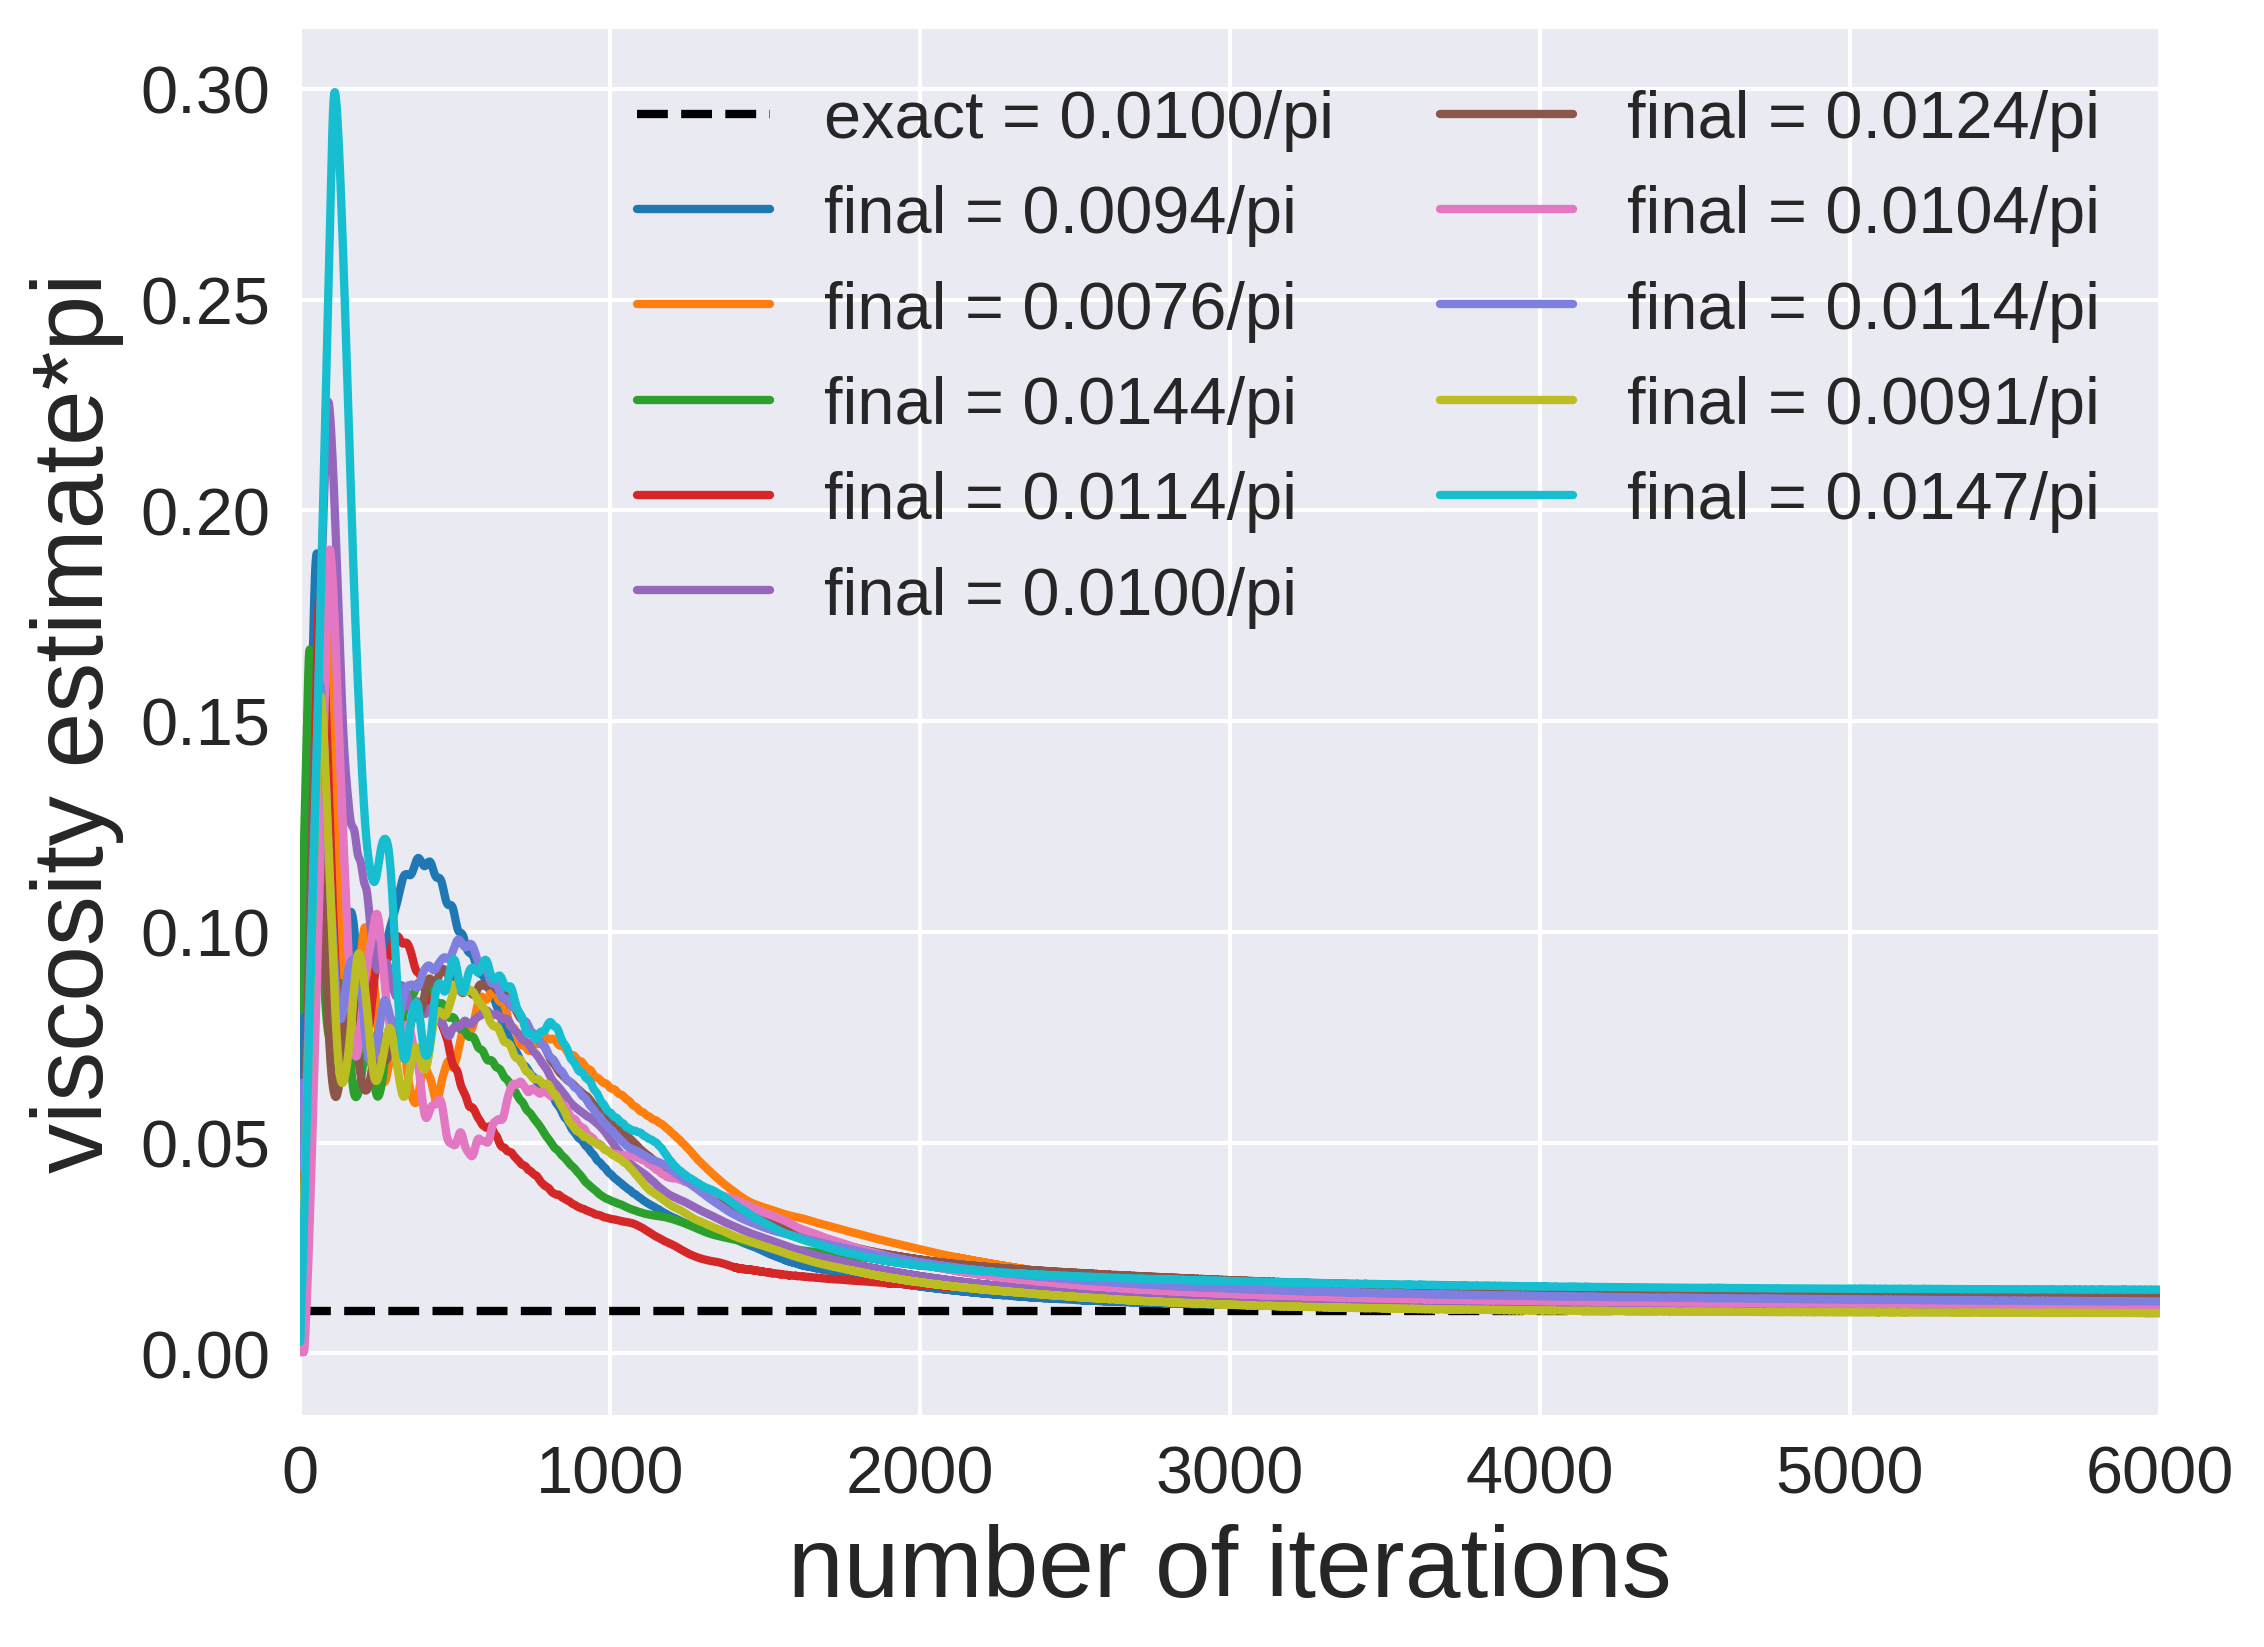

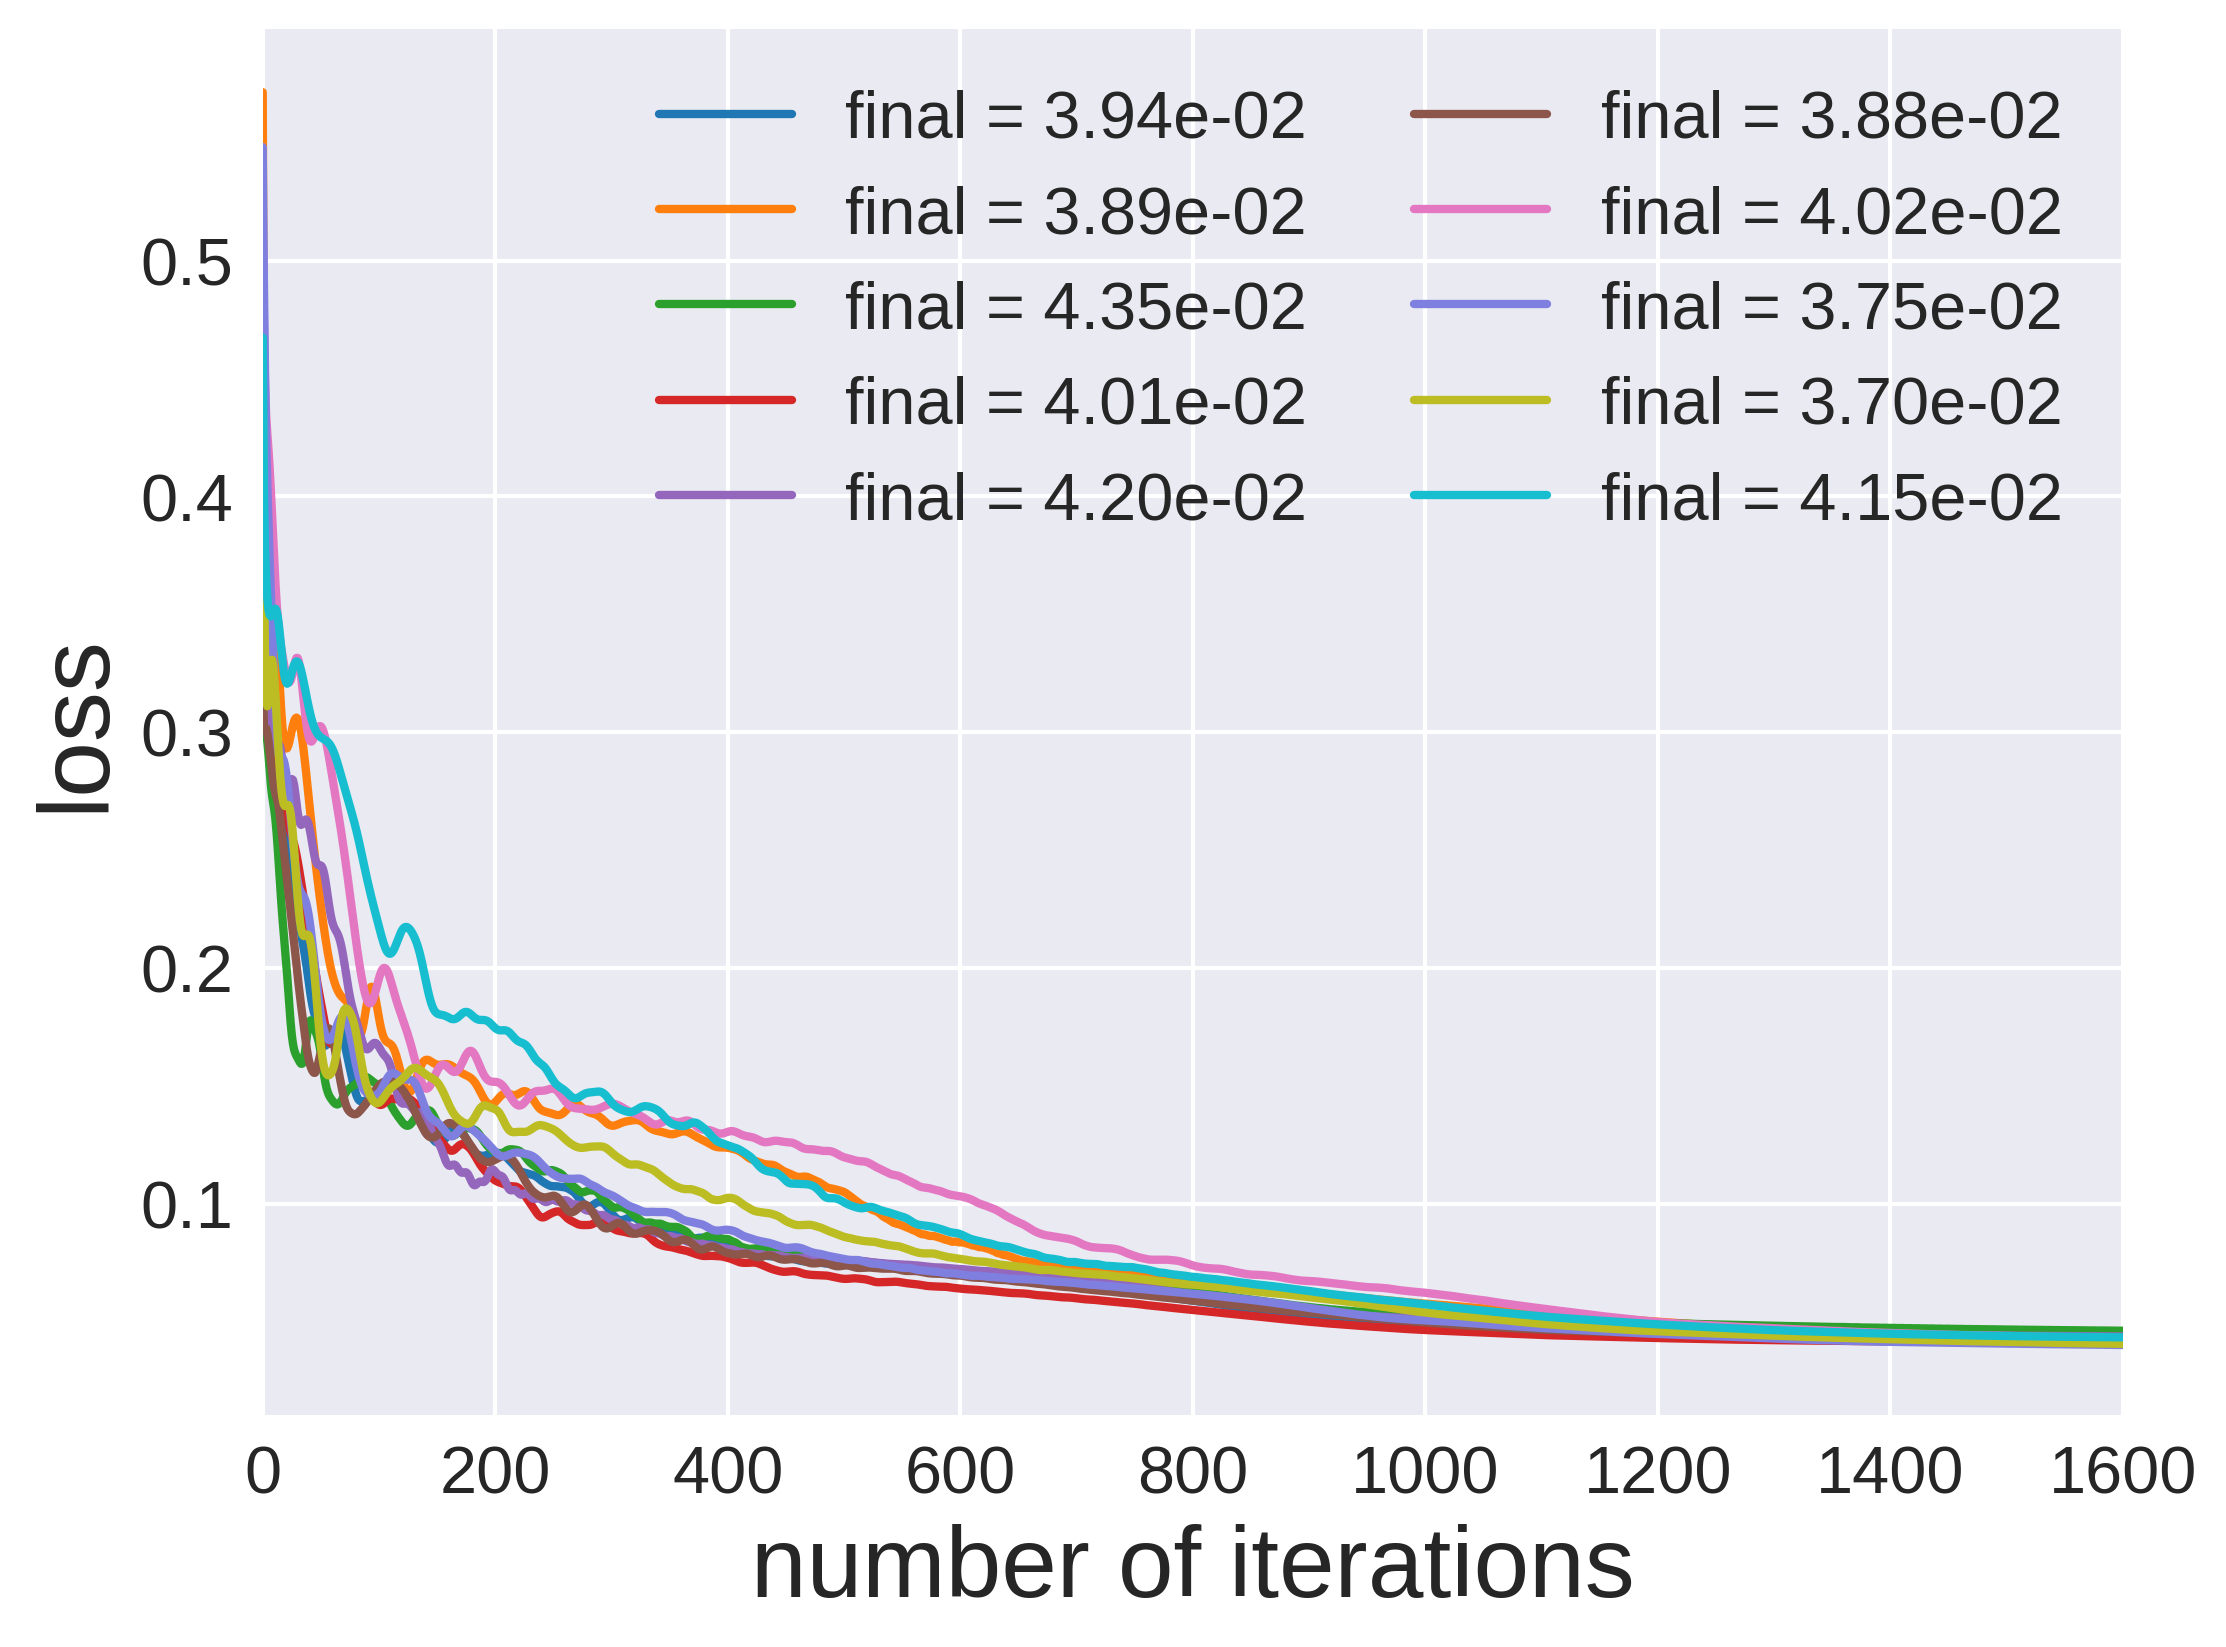

In [ ]:
#Display results

#vhat = np.load('Burgers_Inverse_vhat.npy')

from google.colab import files

colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7fdf','#bcbd22','#17becf']

# plot the evolution of vhat
plt.style.use('seaborn-v0_8')
fig=plt.figure(figsize=(8,6),dpi=300)
plt.xlabel('number of iterations',size=24)
plt.ylabel('viscosity estimate*pi',size=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.hlines(0.01,0,N,colors='black',linestyles='dashed',lw=2,label='exact = {:.4f}/pi'.format(np.pi*nu))
for r in range(M):
  plt.plot(np.arange(N),np.pi*vhat[r,],color=colors[r%10],lw=2,label='final = {:.4f}/pi'.format(np.pi*vhat[r,-1]))
plt.legend(fontsize=16,facecolor='white',ncol=2,columnspacing=1.6)
plt.xlim(0,6000)
fig.savefig('Fig-BurgersPINN_inverse_v.png',bbox_inches="tight",facecolor="white")
files.download('Fig-BurgersPINN_inverse_v.png')
print('viscosity estimate = ({:.4f} +/- {:.4f})/pi'.format(np.mean(np.pi*vhat[:,-1]),np.std(np.pi*vhat[:,-1])))

# plot the evolution of the loss
plt.style.use('seaborn-v0_8')
fig=plt.figure(figsize=(8,6),dpi=300)
plt.xlabel('number of iterations',size=24)
plt.ylabel('loss',size=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
for r in range(M):
  plt.plot(np.arange(N),l[r,],color=colors[r%10],lw=2,label='final = {:.2e}'.format(l[r,-1]))
plt.legend(fontsize=16,facecolor='white',ncol=2,columnspacing=1.6)
plt.xlim(0,1600)
fig.savefig('Fig-BurgersPINN_inverse_e.png',bbox_inches="tight",facecolor="white")
files.download('Fig-BurgersPINN_inverse_e.png')

(a) Modify the code to plot the evolution of the viscosity
estimate and the training loss, over 10 independent runs, for Nx = 16, 32, 64
uniformly-distributed spatial sensors, and the same 8 temporal snapshots as in the original
code. What do you observe?

(b) Generate a barplot of the relative error of the parameter estimate at the end of training,
showing the mean and standard error bar over 10 independent runs, for Nx = 16, 32, 64
spatial sensors, and the same 8 temporal snapshots as in the original code, and varying
the true viscosity values $\nu$ = 0.1/$\pi$, 0.03/$\pi$, 0.01/$\pi$, 0.007/$\pi$. Group the results in a single
bar plot, with the viscosity in the x axis, the relative error in the y axis, and using
different bar colors to indicate the number of sensors. Add the standard deviation error
bars to the plot as well. Explain in detail what the e↵ect of the number of sensors and
the true viscosity is on the accuracy of the results.

## In-class exercise:  physics-informed Gaussian process

This python script demonstrates coding and training a physics-informed Gaussian process to solve the classical univariate advection of a tracer in a moving fluid, with a sinusoidal initial condition.

The evolution of the tracer concentration $q(x,t)$ in a pipe, for $0 \leq x \leq L$ and $t>0$, is governed by the univariate linear advection hyperbolic PDE:
  \begin{aligned}
  q_t + vq_x = 0
  \end{aligned}
where $v$ is the constant velocity. The initial condition is  
\begin{equation}
  q(x,0) = \sin(x)
\end{equation}
This simple problem has as solution:
\begin{aligned}
     q(x,t) = \sin(x-vt)
  \end{aligned}
In other words, the initial sinusoisal profile is simply advected to the left with speed $v$.

In this demo, we assume $L = 16\pi$ and $v = 10$.

In [ ]:
"""
Import libraries
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import cho_factor, cho_solve
from scipy.optimize import minimize
from scipy.stats.qmc import LatinHypercube as lhs

In [ ]:
"""
Problem definition and training data
"""

# parameters of the simulation
A =  1            # amplitude of sinusoisal
xl = 0            # left limit of interval
xr = 16*np.pi     # right limit of interval
ti = 0.0          # initial time
tf = 1.0          # final time
v = 10            # advection speed
delta = 0.000001  # small value to add to the diagonal of K2

# training points (initial + boundary condition points)
Np = [100,100]
N = np.sum(Np)
x = np.concatenate((np.linspace(xl,xr,Np[1]),xl*np.ones(Np[0])))
t = np.concatenate((ti*np.ones(Np[1]),np.linspace(ti,tf,Np[0])))
X = np.hstack((x[:,np.newaxis],t[:,np.newaxis]))

# training points (PDE residual points)
Nres = 800
Z = lhs(2).random(Nres)
Z[:,0] = xl+(xr-xl)*Z[:,0]
Z[:,1] = ti+(tf-ti)*Z[:,1]

# generate the training data responses
Y = np.zeros([N+Nres,1])
Y[0:Np[1],0] = A*np.sin(X[0:Np[1],0])
Y[Np[1]:N,0] = -A*np.sin(v*X[Np[1]:N,1])

In [ ]:
"""
marginal likelihood function
"""
def mrglik(th,X,Y,Z,v):

    N = X.shape[0]
    Nres = Z.shape[0]

    # generate the K2 matrix
    K2 = np.zeros([N+Nres,N+Nres])
    for i in range(N):
        for j in range(N):
            K2[i,j] = th[0]*th[0] * \
            np.exp(-.5*np.power(X[i,0]-X[j,0],2)/th[1]/th[1]-.5*np.power(X[i,1]-X[j,1],2)/th[2]/th[2])
        for j in range(Nres):
            K2[i,N+j] = th[0]*th[0]*((X[i,1]-Z[j,1])/th[2]/th[2]+v*(X[i,0]-Z[j,0])/th[1]/th[1]) * \
            np.exp(-.5*np.power(X[i,0]-Z[j,0],2)/th[1]/th[1]-.5*np.power(X[i,1]-Z[j,1],2)/th[2]/th[2])
    for i in range(Nres):
        for j in range(N):
            K2[N+i,j] = K2[j,N+i]
        for j in range(Nres):
            K2[N+i,N+j] = th[0]*th[0]*(1/th[2]/th[2]+v*v/th[1]/th[1] - \
            np.power((Z[i,1]-Z[j,1])/th[2]/th[2]+v*(Z[i,0]-Z[j,0])/th[1]/th[1],2)) * \
            np.exp(-.5*np.power(Z[i,0]-Z[j,0],2)/th[1]/th[1]-.5*np.power(Z[i,1]-Z[j,1],2)/th[2]/th[2])

    # compute alpha
    L,low = cho_factor(K2+delta*np.eye(N+Nres))
    alpha = cho_solve((L,low),Y)

    return (0.5*Y.T.dot(alpha)+np.sum(np.log(np.diag(L)))+0.5*(N+Nres)*np.log(2*np.pi)).item()

def cb(intermediate_result):
    global Niter
    th = intermediate_result.x
    fun = intermediate_result.fun
    print('{0:4d}   {1: 3.6f}   {2: 3.6f}   {3: 3.6f}   {4: 3.6f}' \
          .format(Niter,th[0],th[1],th[2],-fun))
    Niter += 1

In [ ]:
""""
PIGP training using direct implementation in numpy and scipy
"""

# initialize GP parameters [sigma,lsx,lst]
th = np.array([1,1,1])

Niter = 1
print('{0:4s}   {1:9s}   {2:9s}   {3:9s}   {4:9s}' \
      .format('Iter', ' sigma', ' ls_x', ' ls_t', ' mrglik'))
print('{0:4d}   {1: 3.6f}   {2: 3.6f}   {3: 3.6f}   {4: 3.6f}' \
      .format(0,th[0],th[1],th[2],-mrglik(th,X,Y,Z,v)))
opt=minimize(mrglik,th,args=(X,Y,Z,v),method='L-BFGS-B',bounds=(((0.01,None),)*3),callback=cb)
if opt.success:
    print("Training finished successfully.")
else:
    print("Training failed.")
th = opt.x
mrglik_val = opt.fun
print("Final trained values:")
print("sigma  = {:.6f}".format(th[0]))
print("ls_x   = {:.6f}".format(th[1]))
print("ls_t   = {:.6f}".format(th[2]))
print("mrglik = {:.6f}".format(-mrglik_val))

Iter    sigma       ls_x        ls_t        mrglik  
   0    1.000000    1.000000    1.000000   -18491258.327705
   1    0.422650    0.422650    0.422650   -33573.928275
   2    0.422779    0.414749    0.410788   -24403.412133
   3    0.423009    0.393649    0.378219   -10379.908842
   4    0.423318    0.379527    0.356830   -6278.198583
   5    0.424274    0.364154    0.334138   -4058.267826
   6    0.426205    0.350467    0.311600   -2963.641787
   7    0.429455    0.340336    0.285442   -2358.791461
   8    0.433750    0.338396    0.258182   -2073.908710
   9    0.439471    0.348363    0.228911   -1910.400000
  10    0.448926    0.382599    0.184416   -1755.732335
  11    0.456860    0.429750    0.152213   -1654.610374
  12    0.463894    0.509483    0.124234   -1520.571924
  13    0.471402    0.637908    0.116295   -1243.199180
  14    0.533382    1.490576    0.153402    1012.992884
  15    0.581152    1.970537    0.190097    1532.977993
  16    0.589400    1.930687    0.174563    

In [ ]:
"""
Prediction on test grid
"""

K2 = np.zeros([N+Nres,N+Nres])
#th = np.array([0.5238*, 0.0126, 0.0000, 0.0001])
for i in range(N):
    for j in range(N):
        K2[i,j] = th[0]*th[0] * \
        np.exp(-.5*np.power(X[i,0]-X[j,0],2)/th[1]/th[1]-.5*np.power(X[i,1]-X[j,1],2)/th[2]/th[2])
    for j in range(Nres):
        K2[i,N+j] = th[0]*th[0]*((X[i,1]-Z[j,1])/th[2]/th[2]+v*(X[i,0]-Z[j,0])/th[1]/th[1]) * \
        np.exp(-.5*np.power(X[i,0]-Z[j,0],2)/th[1]/th[1]-.5*np.power(X[i,1]-Z[j,1],2)/th[2]/th[2])
for i in range(Nres):
    for j in range(N):
        K2[N+i,j] = K2[j,N+i]
    for j in range(Nres):
        K2[N+i,N+j] = th[0]*th[0]*(1/th[2]/th[2]+v*v/th[1]/th[1] - \
        np.power((Z[i,1]-Z[j,1])/th[2]/th[2]+v*(Z[i,0]-Z[j,0])/th[1]/th[1],2)) * \
        np.exp(-.5*np.power(Z[i,0]-Z[j,0],2)/th[1]/th[1]-.5*np.power(Z[i,1]-Z[j,1],2)/th[2]/th[2])

# compute alpha
L,low = cho_factor(K2+delta*np.eye(N+Nres))
alpha = cho_solve((L,low),Y)

# compute images row by row
# due to computational cost of GP prediction
Mx = 400
Mt = 200 # image Mt x Mx
u = np.zeros([Mt,Mx])
u_pm = np.zeros([Mt,Mx])
u_sd = np.zeros([Mt,Mx])
for r,t_star in enumerate(np.linspace(ti,tf,Mt)): # time slice

    print("r = "+str(r))
    print("t_star = {:.2f}".format(t_star))

    xs = np.linspace(xl,xr,Mx)
    X_star = np.hstack((xs[:,np.newaxis],t_star*np.ones([Mx,1])))

    # generate the K0 matrix
    K0 = np.zeros([Mx,Mx])
    for i in range(Mx):
        for j in range(Mx):
            K0[i,j] = th[0]*th[0]*np.exp(-.5*np.power(X_star[i,0]-X_star[j,0],2)/th[1]/th[1] - \
                      .5*np.power(X_star[i,1]-X_star[j,1],2)/th[2]/th[2])

    # generate the K1 matrix
    K1 = np.zeros([Mx,N+Nres])
    for i in range(Mx):
        for j in range(N):
            K1[i,j] = th[0]*th[0]*np.exp(-.5*np.power(X_star[i,0]-X[j,0],2)/th[1]/th[1] - \
                      .5*np.power(X_star[i,1]-X[j,1],2)/th[2]/th[2])
        for j in range(Nres):
            K1[i,N+j] = th[0]*th[0]*((X_star[i,1]-Z[j,1])/th[2]/th[2]+v*(X_star[i,0]-Z[j,0])/th[1]/th[1]) * \
            np.exp(-.5*np.power(X_star[i,0]-Z[j,0],2)/th[1]/th[1]-.5*np.power(X_star[i,1]-Z[j,1],2)/th[2]/th[2])

    # analytical solution on test grid
    for i in range(Mx):
        u[r,i] = A*np.sin(X_star[i,0]-v*X_star[i,1])

    # predict on test
    u_pm[r,:] = K1.dot(alpha).flatten() # posterior mean
    w  = cho_solve((L,low),K1.T)
    Yc = K0 - K1.dot(w)
    u_sd[r,:] = np.sqrt(np.diag(Yc)).flatten() # posterior variance

r = 0
t_star = 0.00
r = 1
t_star = 0.01
r = 2
t_star = 0.01
r = 3
t_star = 0.02
r = 4
t_star = 0.02
r = 5
t_star = 0.03
r = 6
t_star = 0.03
r = 7
t_star = 0.04
r = 8
t_star = 0.04
r = 9
t_star = 0.05
r = 10
t_star = 0.05
r = 11
t_star = 0.06
r = 12
t_star = 0.06
r = 13
t_star = 0.07
r = 14
t_star = 0.07
r = 15
t_star = 0.08
r = 16
t_star = 0.08
r = 17
t_star = 0.09
r = 18
t_star = 0.09
r = 19
t_star = 0.10
r = 20
t_star = 0.10
r = 21
t_star = 0.11
r = 22
t_star = 0.11
r = 23
t_star = 0.12
r = 24
t_star = 0.12
r = 25
t_star = 0.13
r = 26
t_star = 0.13
r = 27
t_star = 0.14
r = 28
t_star = 0.14
r = 29
t_star = 0.15
r = 30
t_star = 0.15
r = 31
t_star = 0.16
r = 32
t_star = 0.16
r = 33
t_star = 0.17
r = 34
t_star = 0.17
r = 35
t_star = 0.18
r = 36
t_star = 0.18
r = 37
t_star = 0.19
r = 38
t_star = 0.19
r = 39
t_star = 0.20
r = 40
t_star = 0.20
r = 41
t_star = 0.21
r = 42
t_star = 0.21
r = 43
t_star = 0.22
r = 44
t_star = 0.22
r = 45
t_star = 0.23
r = 46
t_star = 0.23
r = 47
t_star = 0.24
r 

L2 error: 7.5037e-04


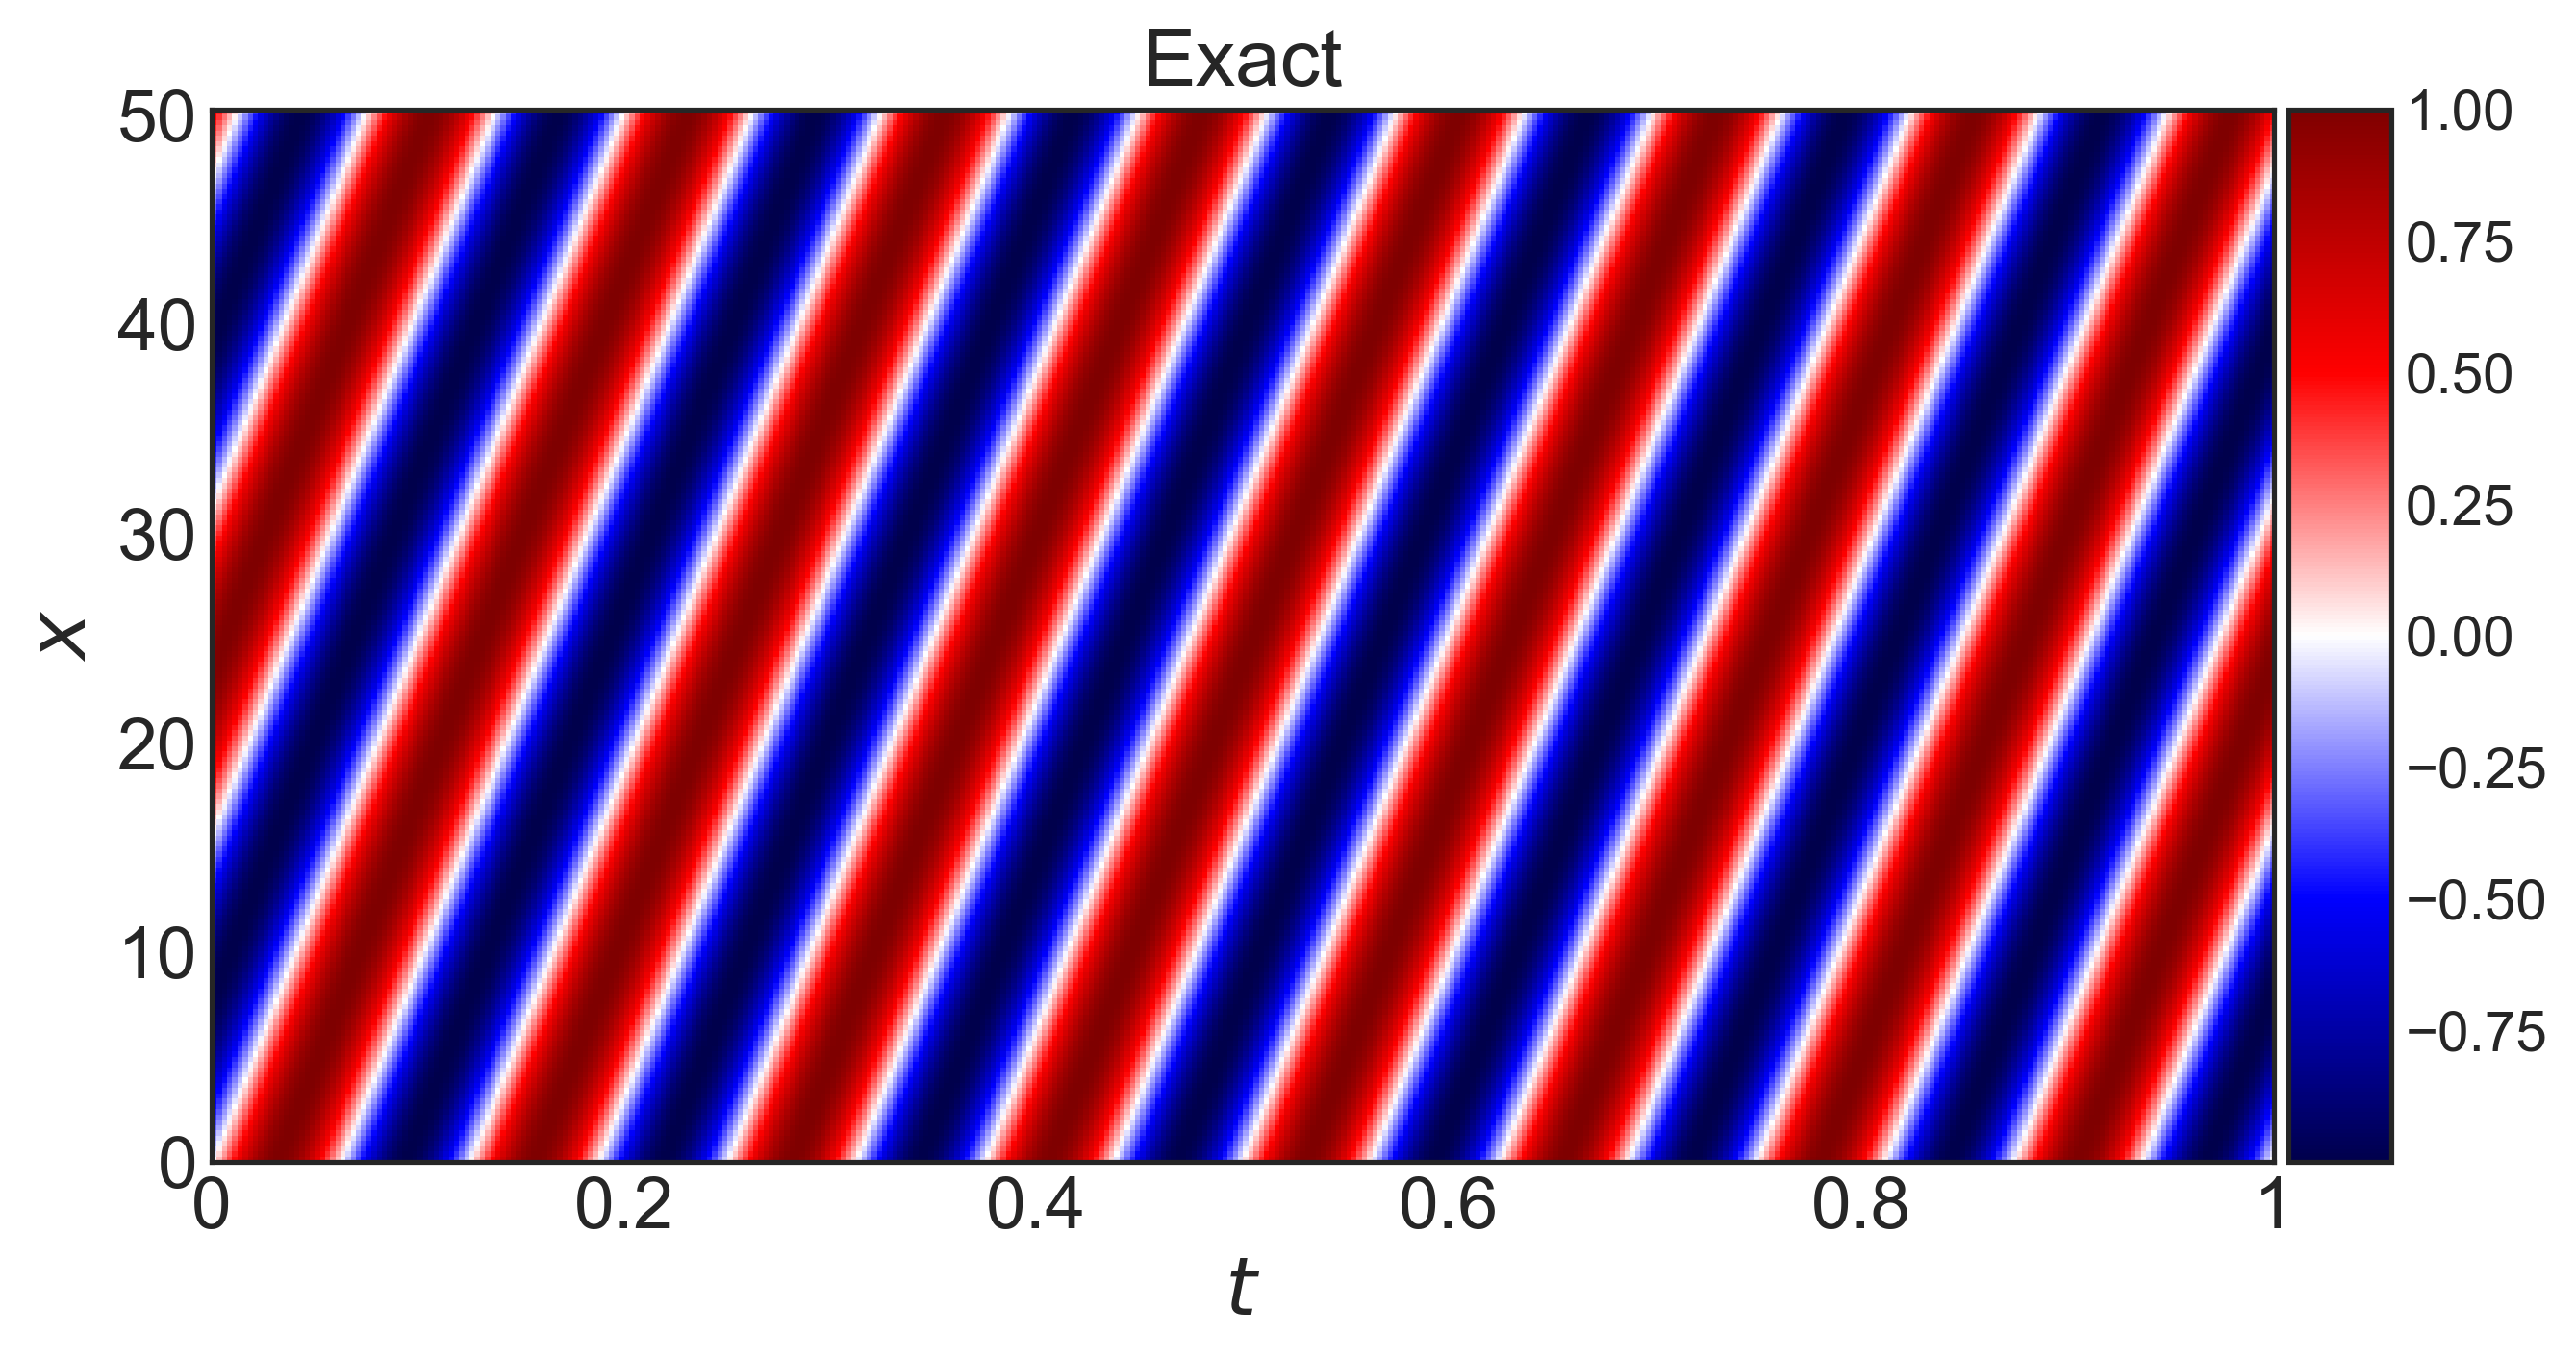

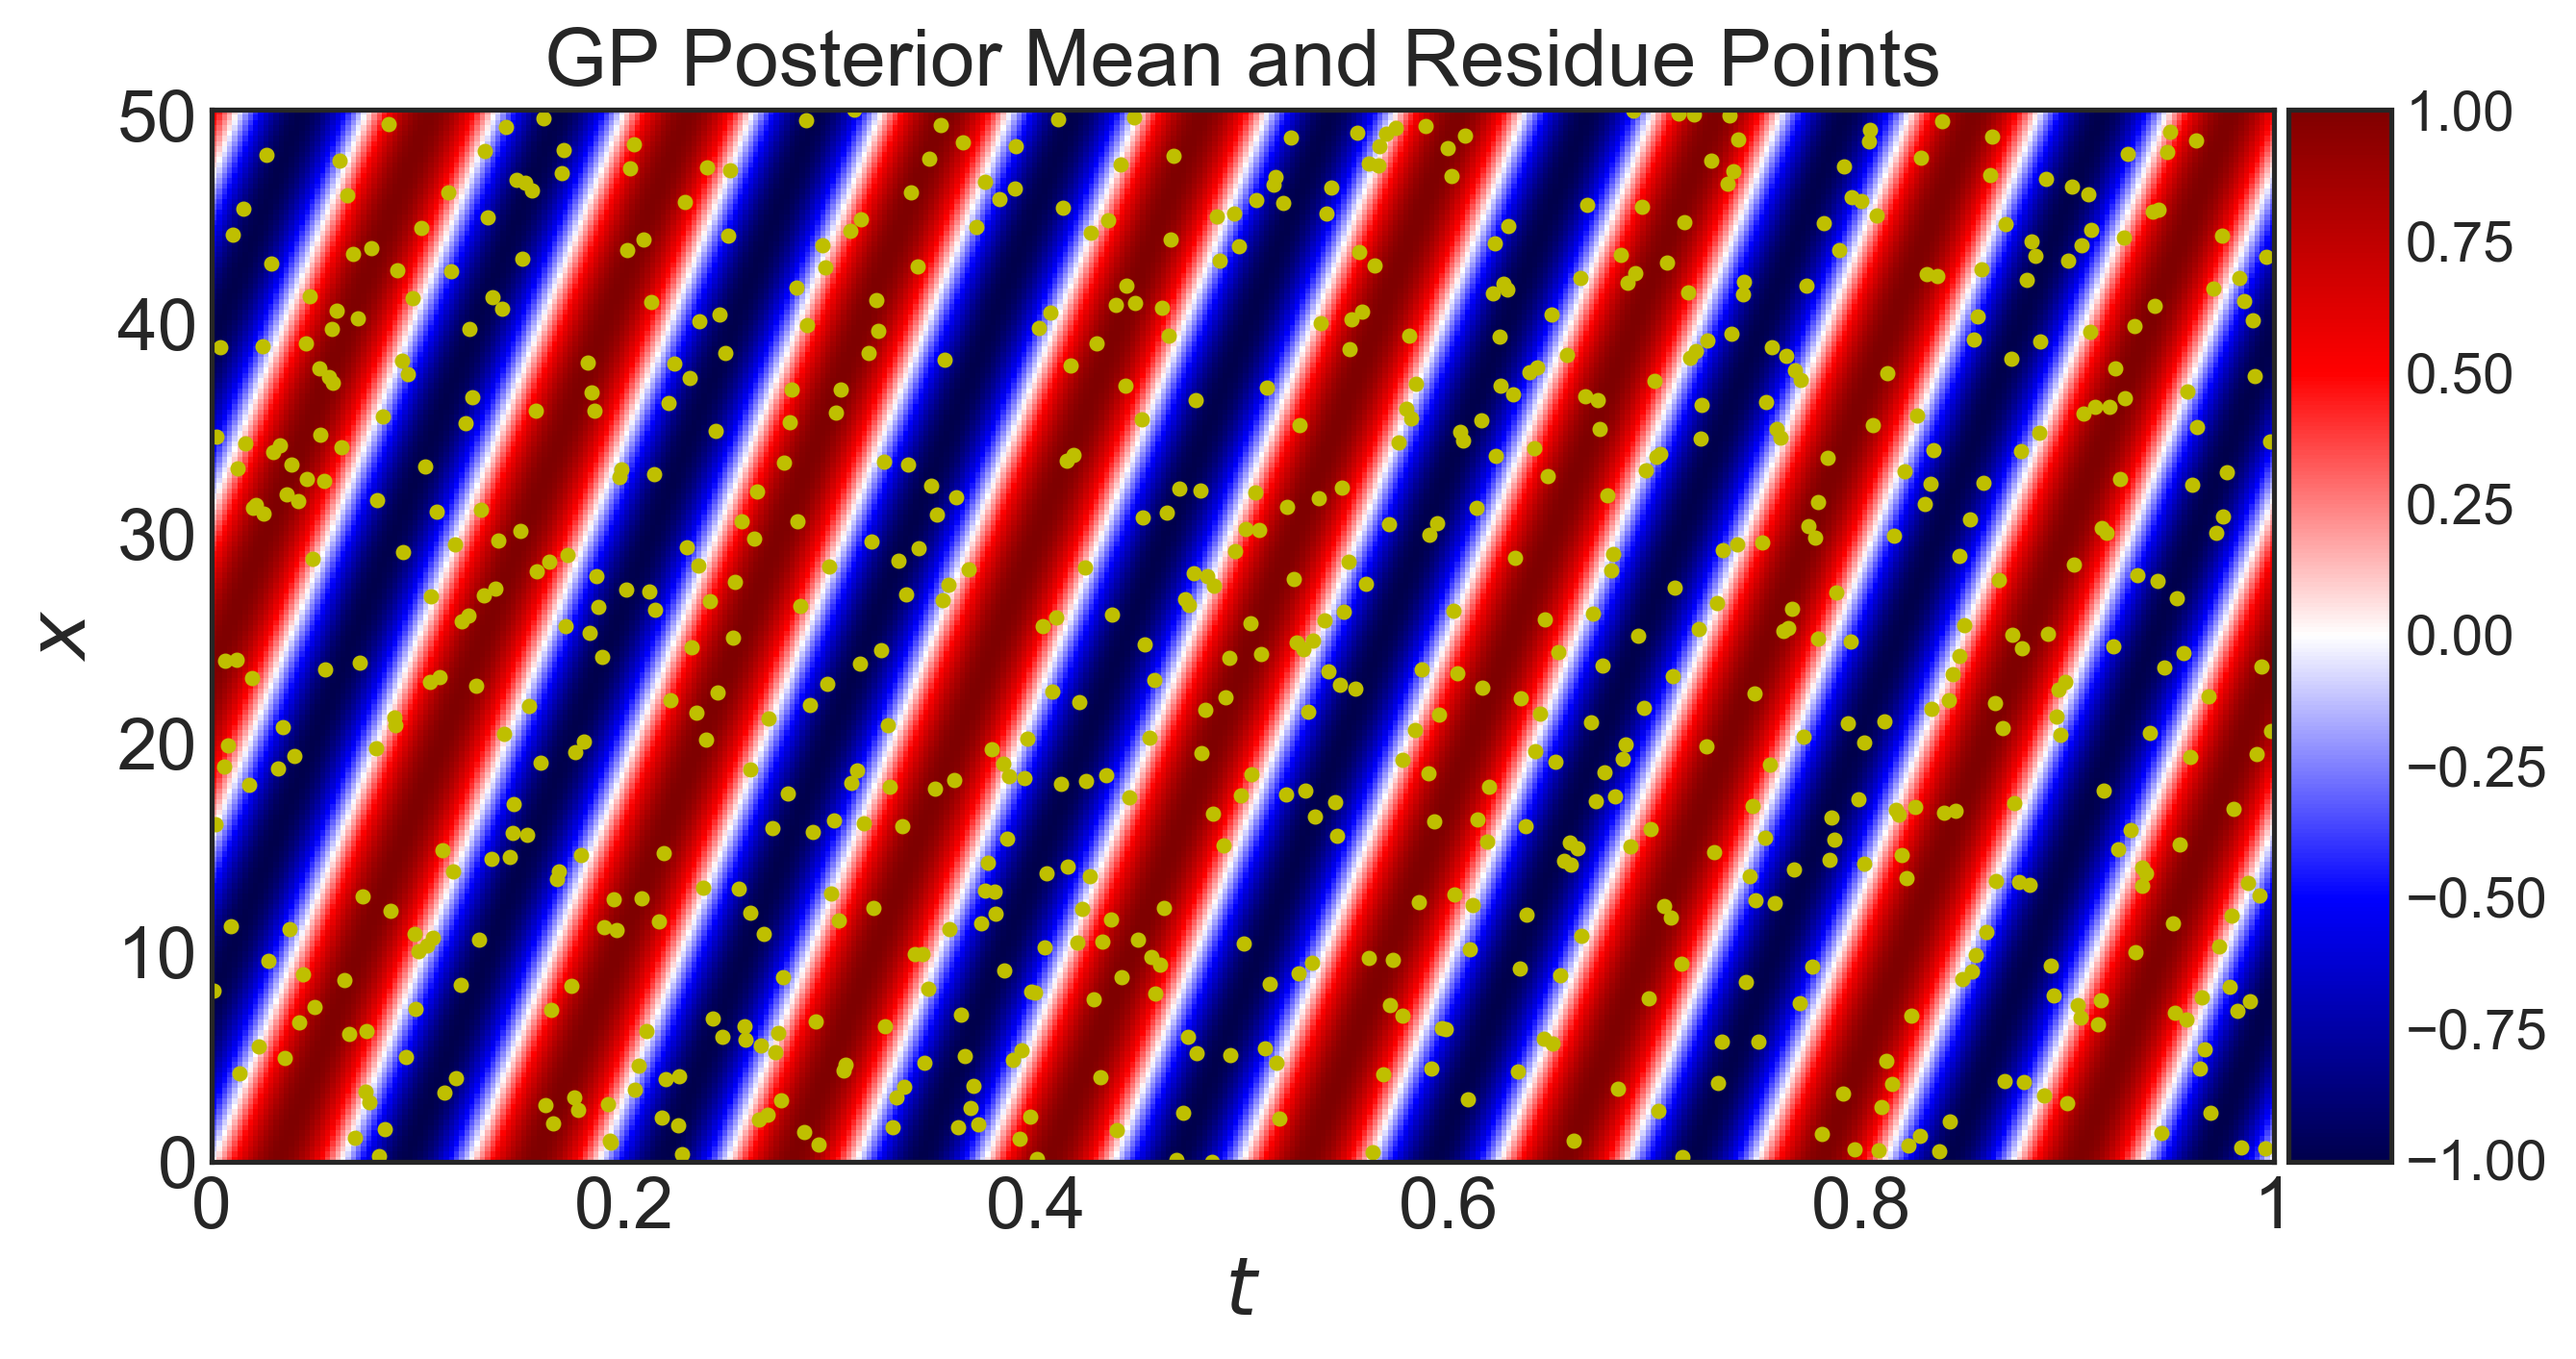

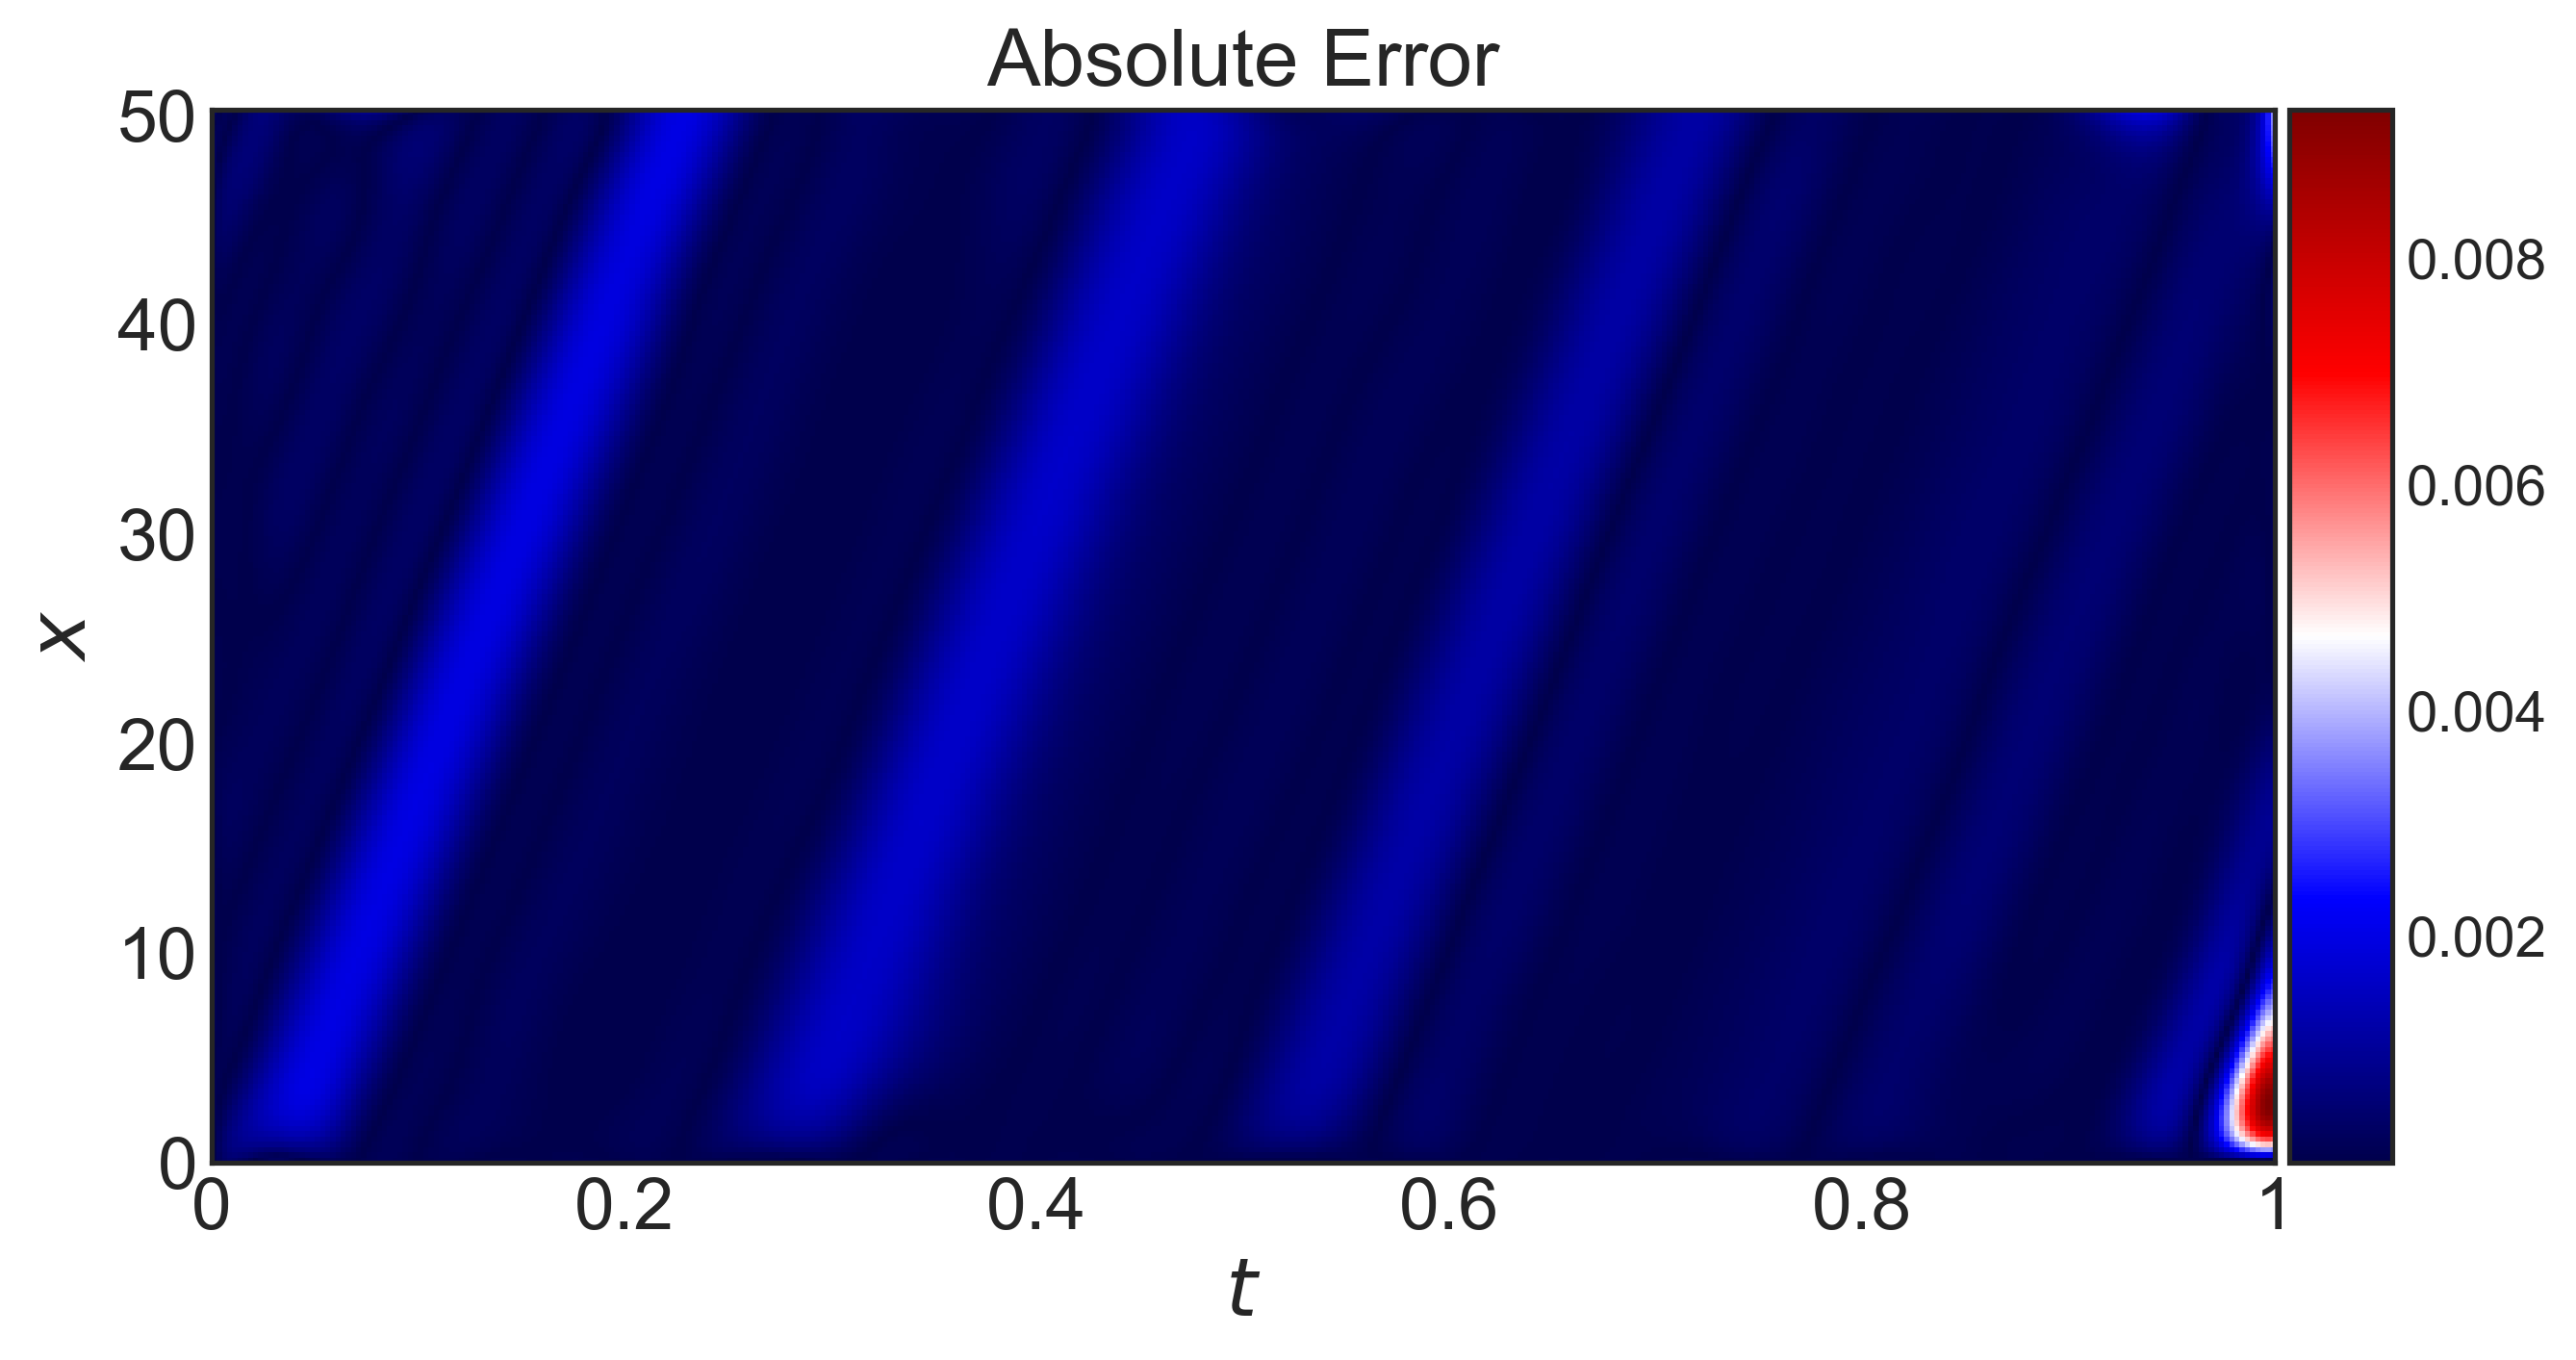

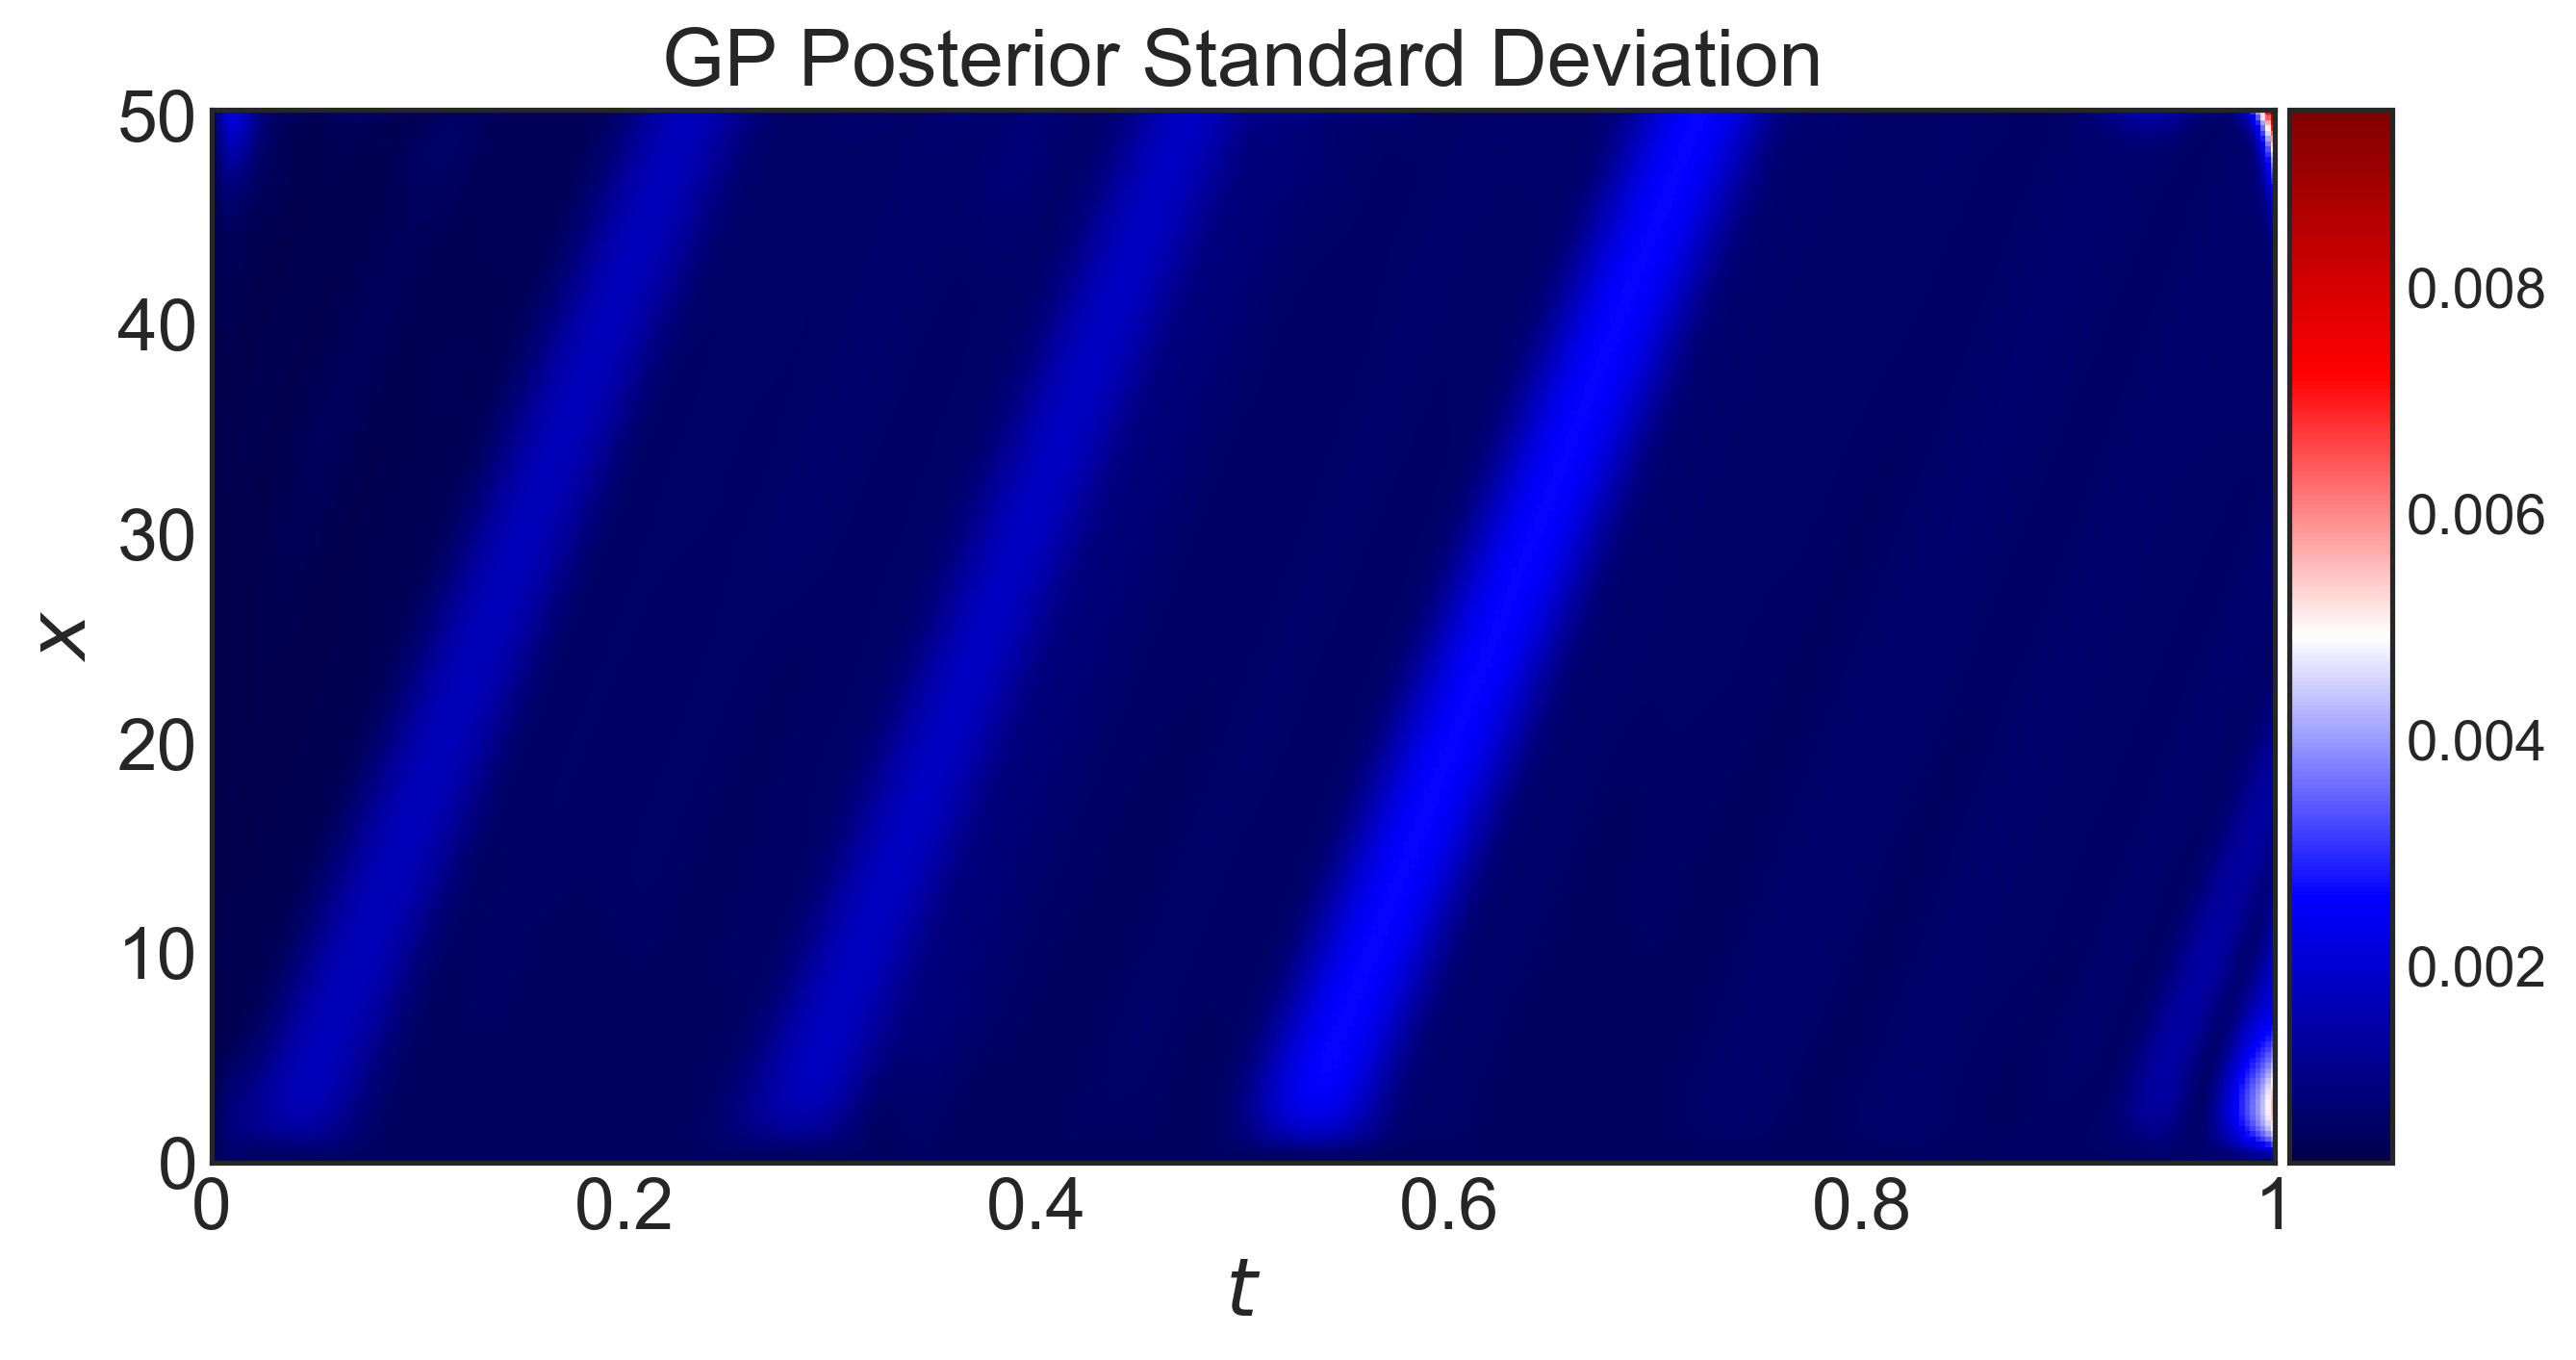

In [ ]:
"""
Display results
"""

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
#from google.colab import files

def figsize(scale, nplots = 1):
    fig_width_pt = 390.0                          # get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                     # convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0          # aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale  # width in inches
    fig_height = nplots*fig_width*golden_mean     # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

# L2 error
err = np.linalg.norm(u_pm.T-u.T,2)/np.linalg.norm(u.T,2)
print('L2 error: %.4e' % (err))

# Exact
plt.style.use('seaborn-v0_8-white')
fig = plt.figure(figsize=figsize(2,2),dpi=300)
gs0 = gridspec.GridSpec(1,1)
gs0.update(top=1-0.06,bottom=1-1/3,left=0.2,right=.9,wspace=0.25)
ax = plt.subplot(gs0[0,0])
im=ax.imshow(u,interpolation='nearest',cmap='seismic',
             extent=[ti,tf,xl,xr],origin='lower',aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%",pad=0.05)
cbar=fig.colorbar(im,cax=cax)
cbar.ax.tick_params(labelsize=14)
ax.tick_params(axis='both',which='major',labelsize=18)
ax.set_xticks(np.arange(0,1.01,0.2),labels=['0','0.2','0.4','0.6','0.8','1'])
ax.set_ylabel('$x$',fontsize=20)
ax.set_xlabel('$t$',fontsize=20)
ax.set_title('Exact',fontsize=20)
plt.show()
fig.savefig('Fig-AdvectionGP_exact.png',bbox_inches="tight",facecolor="white")
files.download('Fig-AdvectionGP_exact.png')

# Posterior Mean
plt.style.use('seaborn-v0_8-white')
fig = plt.figure(figsize=figsize(2,2),dpi=300)
gs0 = gridspec.GridSpec(1,1)
gs0.update(top=1-0.06,bottom=1-1/3,left=0.2,right=.9,wspace=0.25)
ax = plt.subplot(gs0[0,0])
im=ax.imshow(u_pm,interpolation='nearest',cmap='seismic',
             extent=[ti,tf,xl,xr],origin='lower',aspect='auto')
plt.scatter(Z[:,1],Z[:,0],s=32,marker='.',color='y',alpha=1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right",size="5%",pad=0.05)
cbar=fig.colorbar(im,cax=cax)
cbar.ax.tick_params(labelsize=14)
ax.tick_params(axis='both',which='major',labelsize=18)
ax.set_xticks(np.arange(0,1.01,0.2),labels=['0','0.2','0.4','0.6','0.8','1'])
ax.set_ylabel('$x$',fontsize=20)
ax.set_xlabel('$t$',fontsize=20)
ax.set_title('GP Posterior Mean and Residue Points',fontsize=20)
plt.show()
fig.savefig('Fig-AdvectionGP_postmean.png',bbox_inches="tight",facecolor="white")
files.download('Fig-AdvectionGP_postmean.png')

# |Posterior Mean - Exact|
plt.style.use('seaborn-v0_8-white')
fig = plt.figure(figsize=figsize(2,2),dpi=300)
gs0 = gridspec.GridSpec(1,1)
gs0.update(top=1-0.06,bottom=1-1/3,left=0.2,right=.9,wspace=0.25)
ax = plt.subplot(gs0[0,0])
im=ax.imshow(np.abs(u_pm-u),interpolation='nearest',cmap='seismic',
             extent=[ti,tf,xl,xr],origin='lower',aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar=fig.colorbar(im,cax=cax)
cbar.ax.tick_params(labelsize=14)
ax.tick_params(axis='both',which='major',labelsize=18)
ax.set_xticks(np.arange(0,1.01,0.2),labels=['0','0.2','0.4','0.6','0.8','1'])
ax.set_ylabel('$x$',fontsize=20)
ax.set_xlabel('$t$',fontsize=20)
ax.set_title('Absolute Error',fontsize=20)
plt.show()
fig.savefig('Fig-AdvectionGP_absdiff.png',bbox_inches="tight",facecolor="white")
files.download('Fig-AdvectionGP_absdiff.png')

# Posterior Standard Deviation
plt.style.use('seaborn-v0_8-white')
fig = plt.figure(figsize=figsize(2,2),dpi=300)
gs0 = gridspec.GridSpec(1,1)
gs0.update(top=1-0.06,bottom=1-1/3,left=0.2,right=.9,wspace=0.25)
ax = plt.subplot(gs0[0,0])
im=ax.imshow(u_sd,interpolation='nearest',cmap='seismic',
             extent=[ti,tf,xl,xr],origin='lower',aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right",size="5%",pad=0.05)
cbar=fig.colorbar(im,cax=cax)
cbar.ax.tick_params(labelsize=14)
ax.tick_params(axis='both',which='major',labelsize=18)
ax.set_xticks(np.arange(0,1.01,0.2),labels=['0','0.2','0.4','0.6','0.8','1'])
ax.set_ylabel('$x$',fontsize=20)
ax.set_xlabel('$t$',fontsize=20)
ax.set_title('GP Posterior Standard Deviation',fontsize=20)
plt.show()
fig.savefig('Fig-AdvectionGP_postsd.png',bbox_inches="tight",facecolor="white")
files.download('Fig-AdvectionGP_postsd.png')

(a) Modify the code to compute the GP solution for v = 20, 30,
40, 50, 60. Record the trained values of *k, `x, `t, log-likelihood, and relative L2 error
in each case. What happens to the accuracy of the solution as $\nu$ increases? Is there a
relationship between `x and `t?

(b) Repeat for the 3/2-Matern covariance function. How do you compare the results with
the ones in part (a)?

## In-class exercise:  physics-informed Gaussian process (inverse)

In [ ]:
"""
Import libraries
"""

import numpy as np
import matplotlib.pyplot as plt
from numpy import random as rd
from scipy.linalg import cho_factor, cho_solve
from scipy.optimize import minimize
from scipy.stats.qmc import LatinHypercube as lhs

This python script demonstrates coding and training a physics-informed Gaussian process to find the velocity from scattered noisy data generated by the univariate advection of a tracer in a moving fluid, with a sinusoidal initial condition:
  \begin{aligned}
  q_t + vq_x = 0
  \end{aligned}
where $v$ is the constant velocity. The initial condition is  
\begin{equation}
  q(x,0) = \sin(x)
\end{equation}
This simple problem has as solution:
\begin{aligned}
     q(x,t) = \sin(x-vt)
  \end{aligned}
In other words, the initial sinusoisal profile is simply advected to the left with speed $v$. We assume $L = 16\pi$ and set the unknown velocity to $v = 5$.

In [ ]:
"""
Problem definition and training data
"""

# parameters of the simulation
A =  1           # amplitude of sinusoisal
xl = 0           # left limit of interval
xr = 16*np.pi    # right limit of interval
ti = 0.0         # initial time
tf = 1.0         # final time
v = 10            # advection speed
eps = 0.2        # standard deviation of noise in the data
delta = 0.000001 # small value to add to the diagonal of K2

# training points (noisy data points)
Nx = 128 # uniformly spaced interior sensor locations
Nt = 8  # number of uniformly spaces snapshots
N = Nx*Nt
X = np.zeros([N,2])
X[:,0] = np.repeat(xl+(np.arange(Nx)+0.5)*(xr-xl)/Nx,Nt)
X[:,1] = np.tile(ti+(np.arange(Nt)+0.5)*(tf-ti)/Nt,Nx)

In [ ]:
"""
Marginal likelihood function
"""

def mrglik(lb,th,X,Y,Z):

    N = X.shape[0]
    Nres = Z.shape[0]

    # generate the K2 matrix
    K2 = np.zeros([N+Nres,N+Nres])
    for i in range(N):
        for j in range(N):
            K2[i,j] = th[0]*th[0] * \
            np.exp(-.5*np.power(X[i,0]-X[j,0],2)/th[1]/th[1]-.5*np.power(X[i,1]-X[j,1],2)/th[2]/th[2])
        K2[i,i] += lb[1]*lb[1]
        for j in range(Nres):
            K2[i,N+j] = th[0]*th[0]*((X[i,1]-Z[j,1])/th[2]/th[2]+lb[0]*(X[i,0]-Z[j,0])/th[1]/th[1]) * \
            np.exp(-.5*np.power(X[i,0]-Z[j,0],2)/th[1]/th[1]-.5*np.power(X[i,1]-Z[j,1],2)/th[2]/th[2])
    for i in range(Nres):
        for j in range(N):
            K2[N+i,j] = K2[j,N+i]
        for j in range(Nres):
            K2[N+i,N+j] = th[0]*th[0]*(1/th[2]/th[2]+lb[0]*lb[0]/th[1]/th[1] - \
            np.power((Z[i,1]-Z[j,1])/th[2]/th[2]+lb[0]*(Z[i,0]-Z[j,0])/th[1]/th[1],2)) * \
            np.exp(-.5*np.power(Z[i,0]-Z[j,0],2)/th[1]/th[1]-.5*np.power(Z[i,1]-Z[j,1],2)/th[2]/th[2])

    # generate the derivative of K2 wrt v
    dK2_dv = np.zeros([N+Nres,N+Nres])
    for i in range(N):
        #for j in range(N):
        #    dK2_dlx[i,j] = 0
        for j in range(Nres):
            dK2_dv[i,N+j] = th[0]*th[0]*((X[i,0]-Z[j,0])/th[1]/th[1]) * \
            np.exp(-.5*np.power(X[i,0]-Z[j,0],2)/th[1]/th[1]-.5*np.power(X[i,1]-Z[j,1],2)/th[2]/th[2])
    for i in range(Nres):
        for j in range(N):
            dK2_dv[N+i,j] = dK2_dv[j,N+i]
        for j in range(Nres):
            dK2_dv[N+i,N+j] = (2*th[0]*th[0]/th[1]/th[1])*(lb[0] - \
            ((Z[i,1]-Z[j,1])/th[2]/th[2]+lb[0]*(Z[i,0]-Z[j,0])/th[1]/th[1])*(Z[i,0]-Z[j,0])) * \
            np.exp(-.5*np.power(Z[i,0]-Z[j,0],2)/th[1]/th[1]-.5*np.power(Z[i,1]-Z[j,1],2)/th[2]/th[2])

    # generate the derivative of K2 wrt sig2
    dK2_ds2 = np.diag([2*lb[1]]*N+[0]*Nres)

    # compute alpha
    L,low = cho_factor(K2+delta*np.eye(N+Nres))
    alpha = cho_solve((L,low),Y)

    # compute K2^-1
    K2inv = cho_solve((L,low),np.eye(N+Nres))

    # compute alpha.alpha^T - K_2^-1
    aaK2 = alpha.dot(alpha.T) - K2inv

    # comput log-likelihood and its gradient
    ll = (0.5*Y.T.dot(alpha)+np.sum(np.log(np.diag(L)))+0.5*(N+Nres)*np.log(2*np.pi)).item()
    dll = np.zeros(2)
    dll[0] = -0.5*np.sum(aaK2[:]*dK2_dv[:])
    dll[1] = -0.5*np.sum(aaK2[:]*dK2_ds2[:])

    return (ll,dll)

def cb(intermediate_result):
    global it,r,lb_save,lik
    lb_save[r,:,it] = intermediate_result.x
    lik[r,it] = -intermediate_result.fun
    print('{0:4d}   {1:3.6f}   {2:3.6f}   {3:3.6f}' \
          .format(it,lb_save[r,0,it],lb_save[r,1,it],lik[r,it]))
    it += 1

In [ ]:
""""
PIGP training using direct implementation in numpy and scipy
"""

# Note: only the velocity and the noise std
# are estimated, while the kernel hyperparameters
# are kept fixed (see book text). No bounds are
# placed on the velocity and std estimates. The
# former can be positive or negative, while the
# latter enters only through the variance. The
# std estimate should be interpreted only by
# its magnitude (the sign can be diregarded).

# initialize GP parameters [sigma_k,lx,lt]
th = np.array([3.3078,2.6910,0.2377])

M = 10     # number of repetitions
Nres = 800 # training points (PDE residual points)
maxiter = 40
lik = np.zeros([M,maxiter])
lb_save = np.zeros([M,2,maxiter])

for r in range(M):

    # generate the training data responses
    Y = np.zeros([N+Nres,1])
    Y[0:N,0] = A*np.sin(X[0:N,0]-v*X[0:N,1]) + rd.normal(0,eps,N)
    #Y[N:-1,0] = 0

    # training points (PDE residual points)
    Z = lhs(2).random(Nres)
    Z[:,0] = xl+(xr-xl)*Z[:,0]
    Z[:,1] = ti+(tf-ti)*Z[:,1]

    rng = np.random.default_rng()
    lb = np.array([20*rng.random(),1.0]) # initial parameter guess
    print('\nrepetition: '+str(r))
    print('{0:4s}   {1:9s}   {2:9s}   {3:9s}'.format('Iter', 'v', 'sig', 'mrglik'))
    lb_save[r,:,0] = lb
    lik[r,0] = -mrglik(lb,th,X,Y,Z)[0]
    print('{0:4d}   {1:3.6f}   {2:3.6f}   {3:3.6f}' \
          .format(0,lb_save[r,0,0],lb_save[r,1,0],lik[r,0]))
    it = 1
    opt=minimize(mrglik,lb,args=(th,X,Y,Z),method='L-BFGS-B',jac=True,
                 options={"maxiter":maxiter},callback=cb)
    lb_save[r,0,it:] = opt.x[0]
    lb_save[r,1,it:] = opt.x[1]
    lik[r,it:] = -opt.fun
    print("Final trained values:")
    print("v      = {:.6f}".format(lb_save[r,0,it]))
    print("sig    = {:.6f}".format(lb_save[r,1,it]))
    print("mrglik = {:.6f}".format(lik[r,it]))


repetition: 0
Iter   v           sig         mrglik   
   0   19.262508   1.000000   629.711306
   1   19.249106   0.667288   701.503939
   2   19.245950   0.798385   703.470125
   3   19.242080   0.746385   710.379485
   4   19.233739   0.727653   710.900666
   5   19.205672   0.737092   711.432165
   6   19.105636   0.747303   713.013534
   7   18.405597   0.786485   722.312023
   8   16.507269   0.852932   745.040138
   9   8.727394   1.064330   914.046126
  10   10.079838   0.981716   937.999052
  11   10.885085   0.335313   1471.152341
  12   10.856786   0.258042   1503.848489
  13   10.522113   0.202146   1658.896241
  14   10.186377   0.180344   1785.071321
  15   9.860396   0.224280   1851.439645
  16   9.834047   0.213049   1853.873977
  17   9.864918   0.211740   1854.457832
  18   9.872071   0.211148   1854.480141
  19   9.871894   0.211224   1854.480245
  20   9.871892   0.211223   1854.480249
Final trained values:
v      = 9.871892
sig    = 0.211223
mrglik = 1854.480249



velocity estimate = 8.9141 +/- 2.7280
velocity relative error = 1.09e-01 +/- 2.73e-01
noise standard deviation estimate = 0.2596 +/- 0.1557
noise standard deviation relative error = 2.98e-01 +/- 1.36e+01


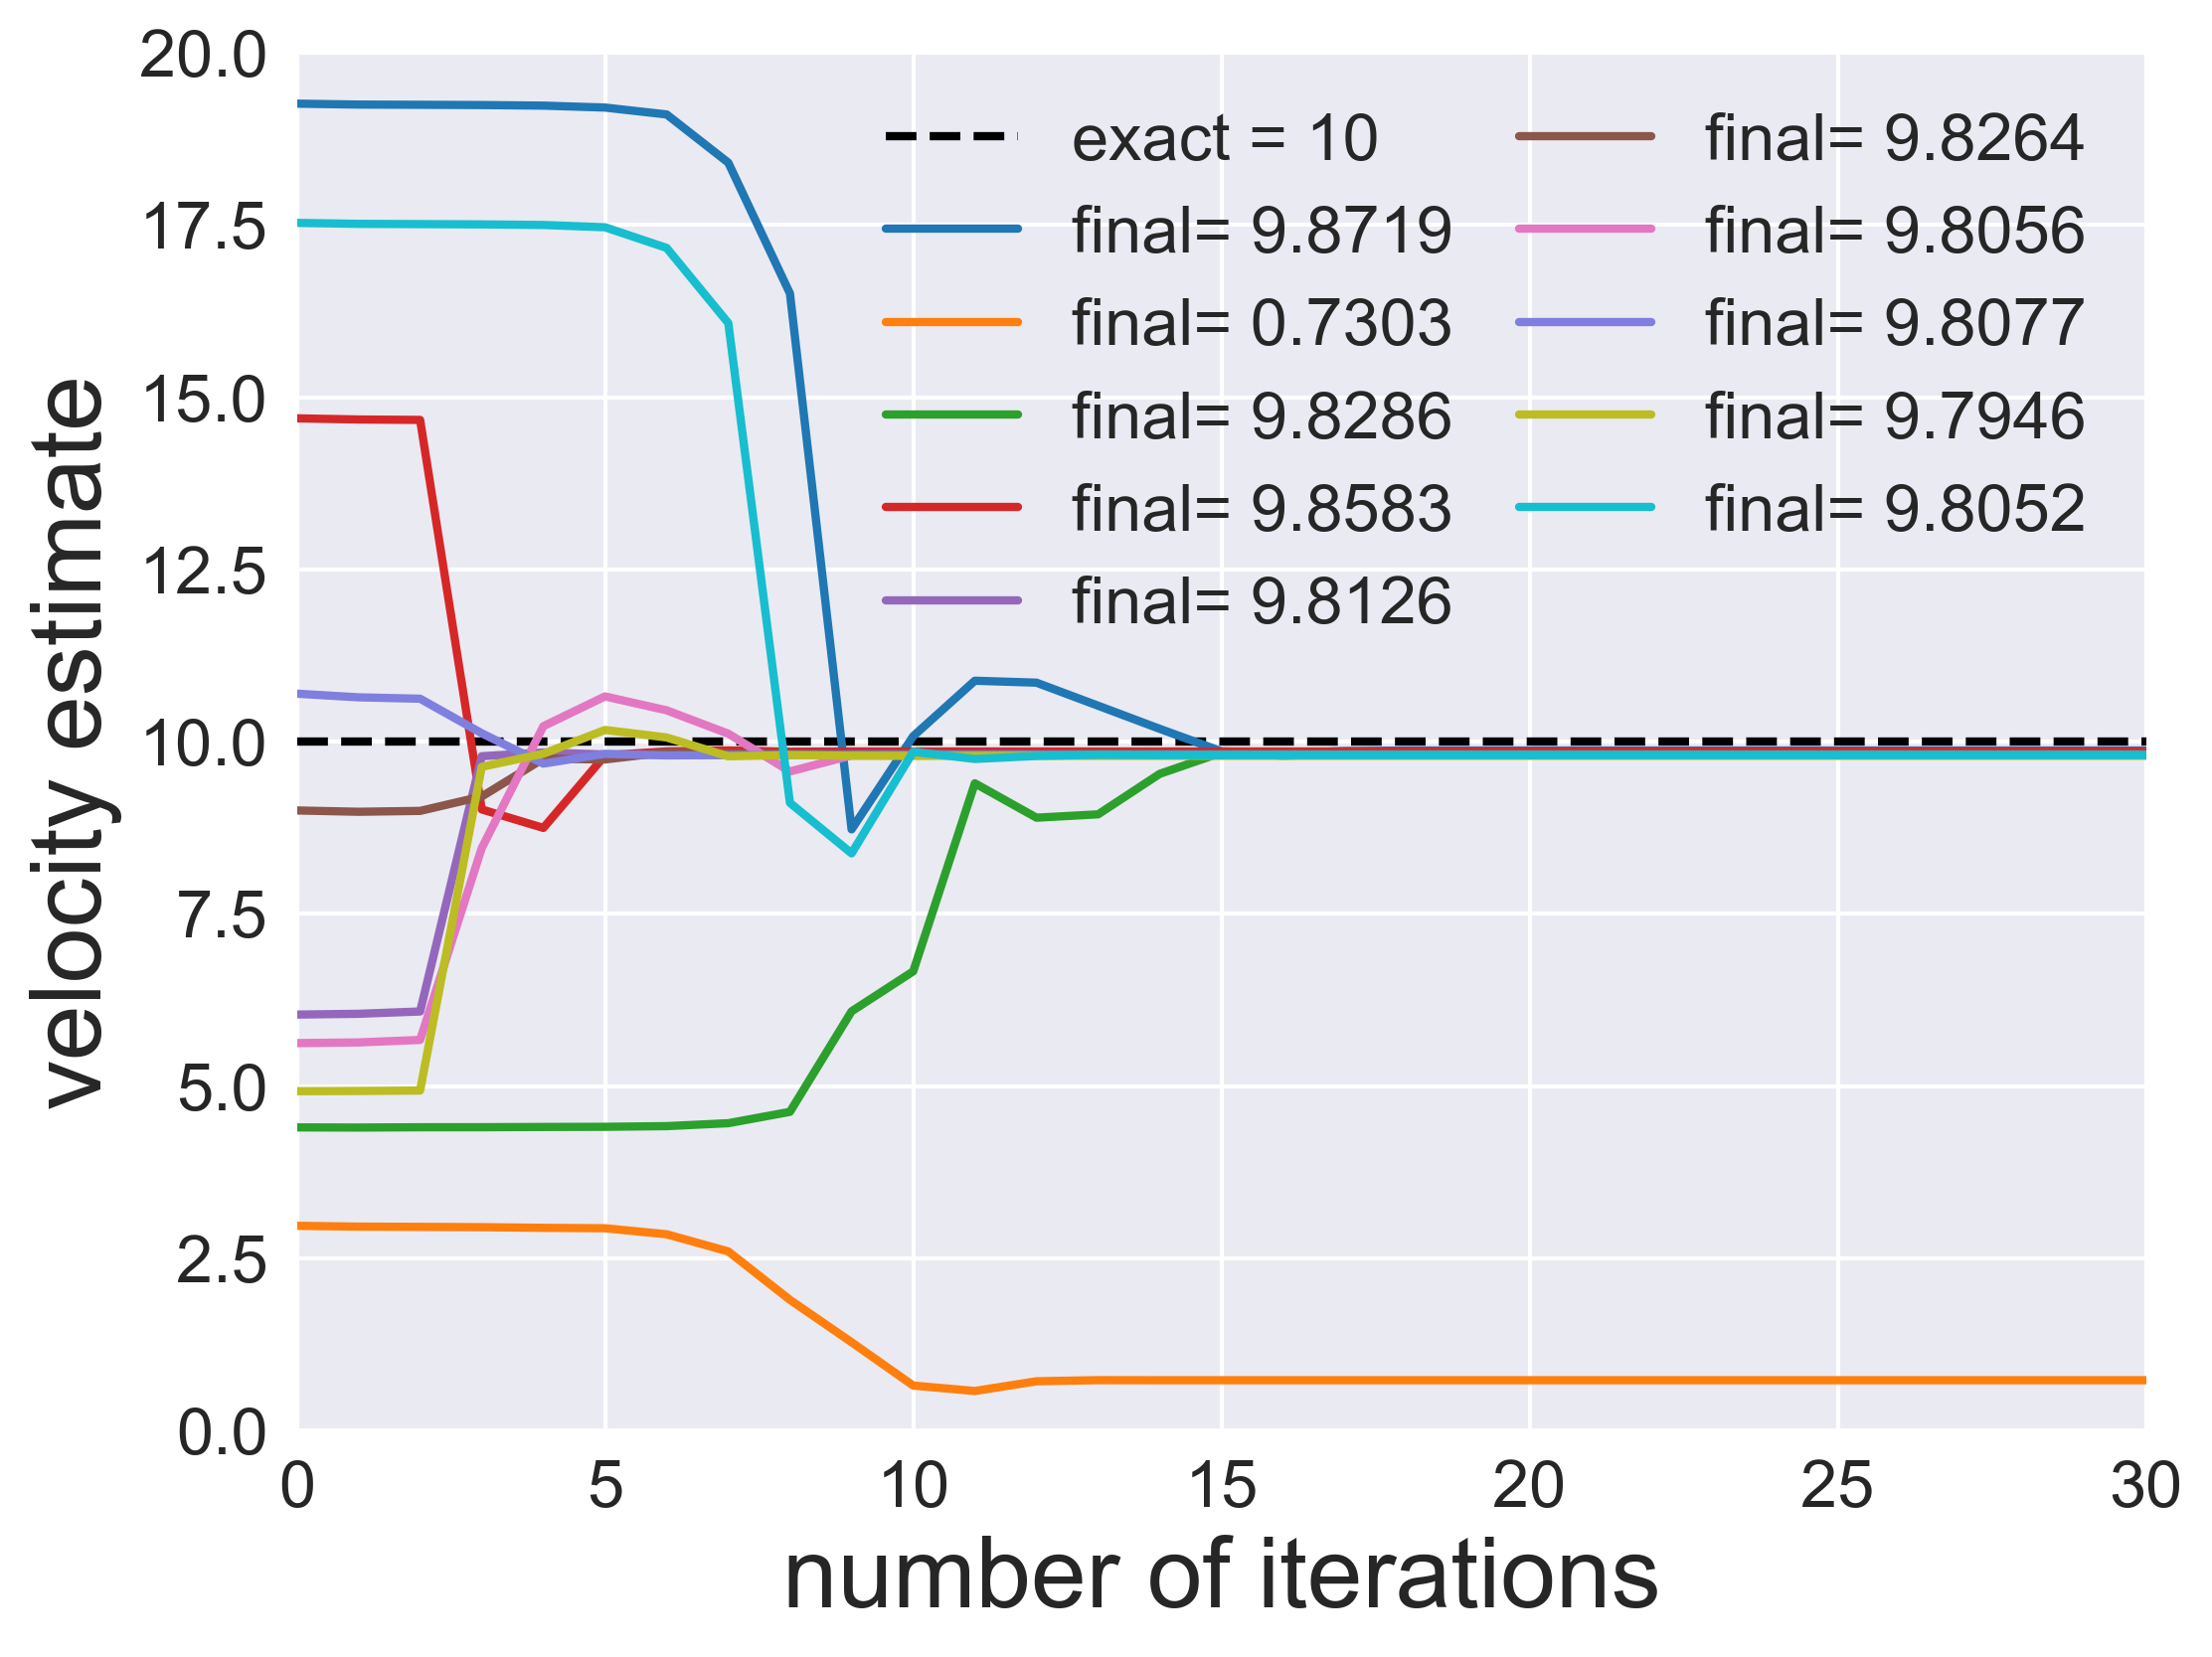

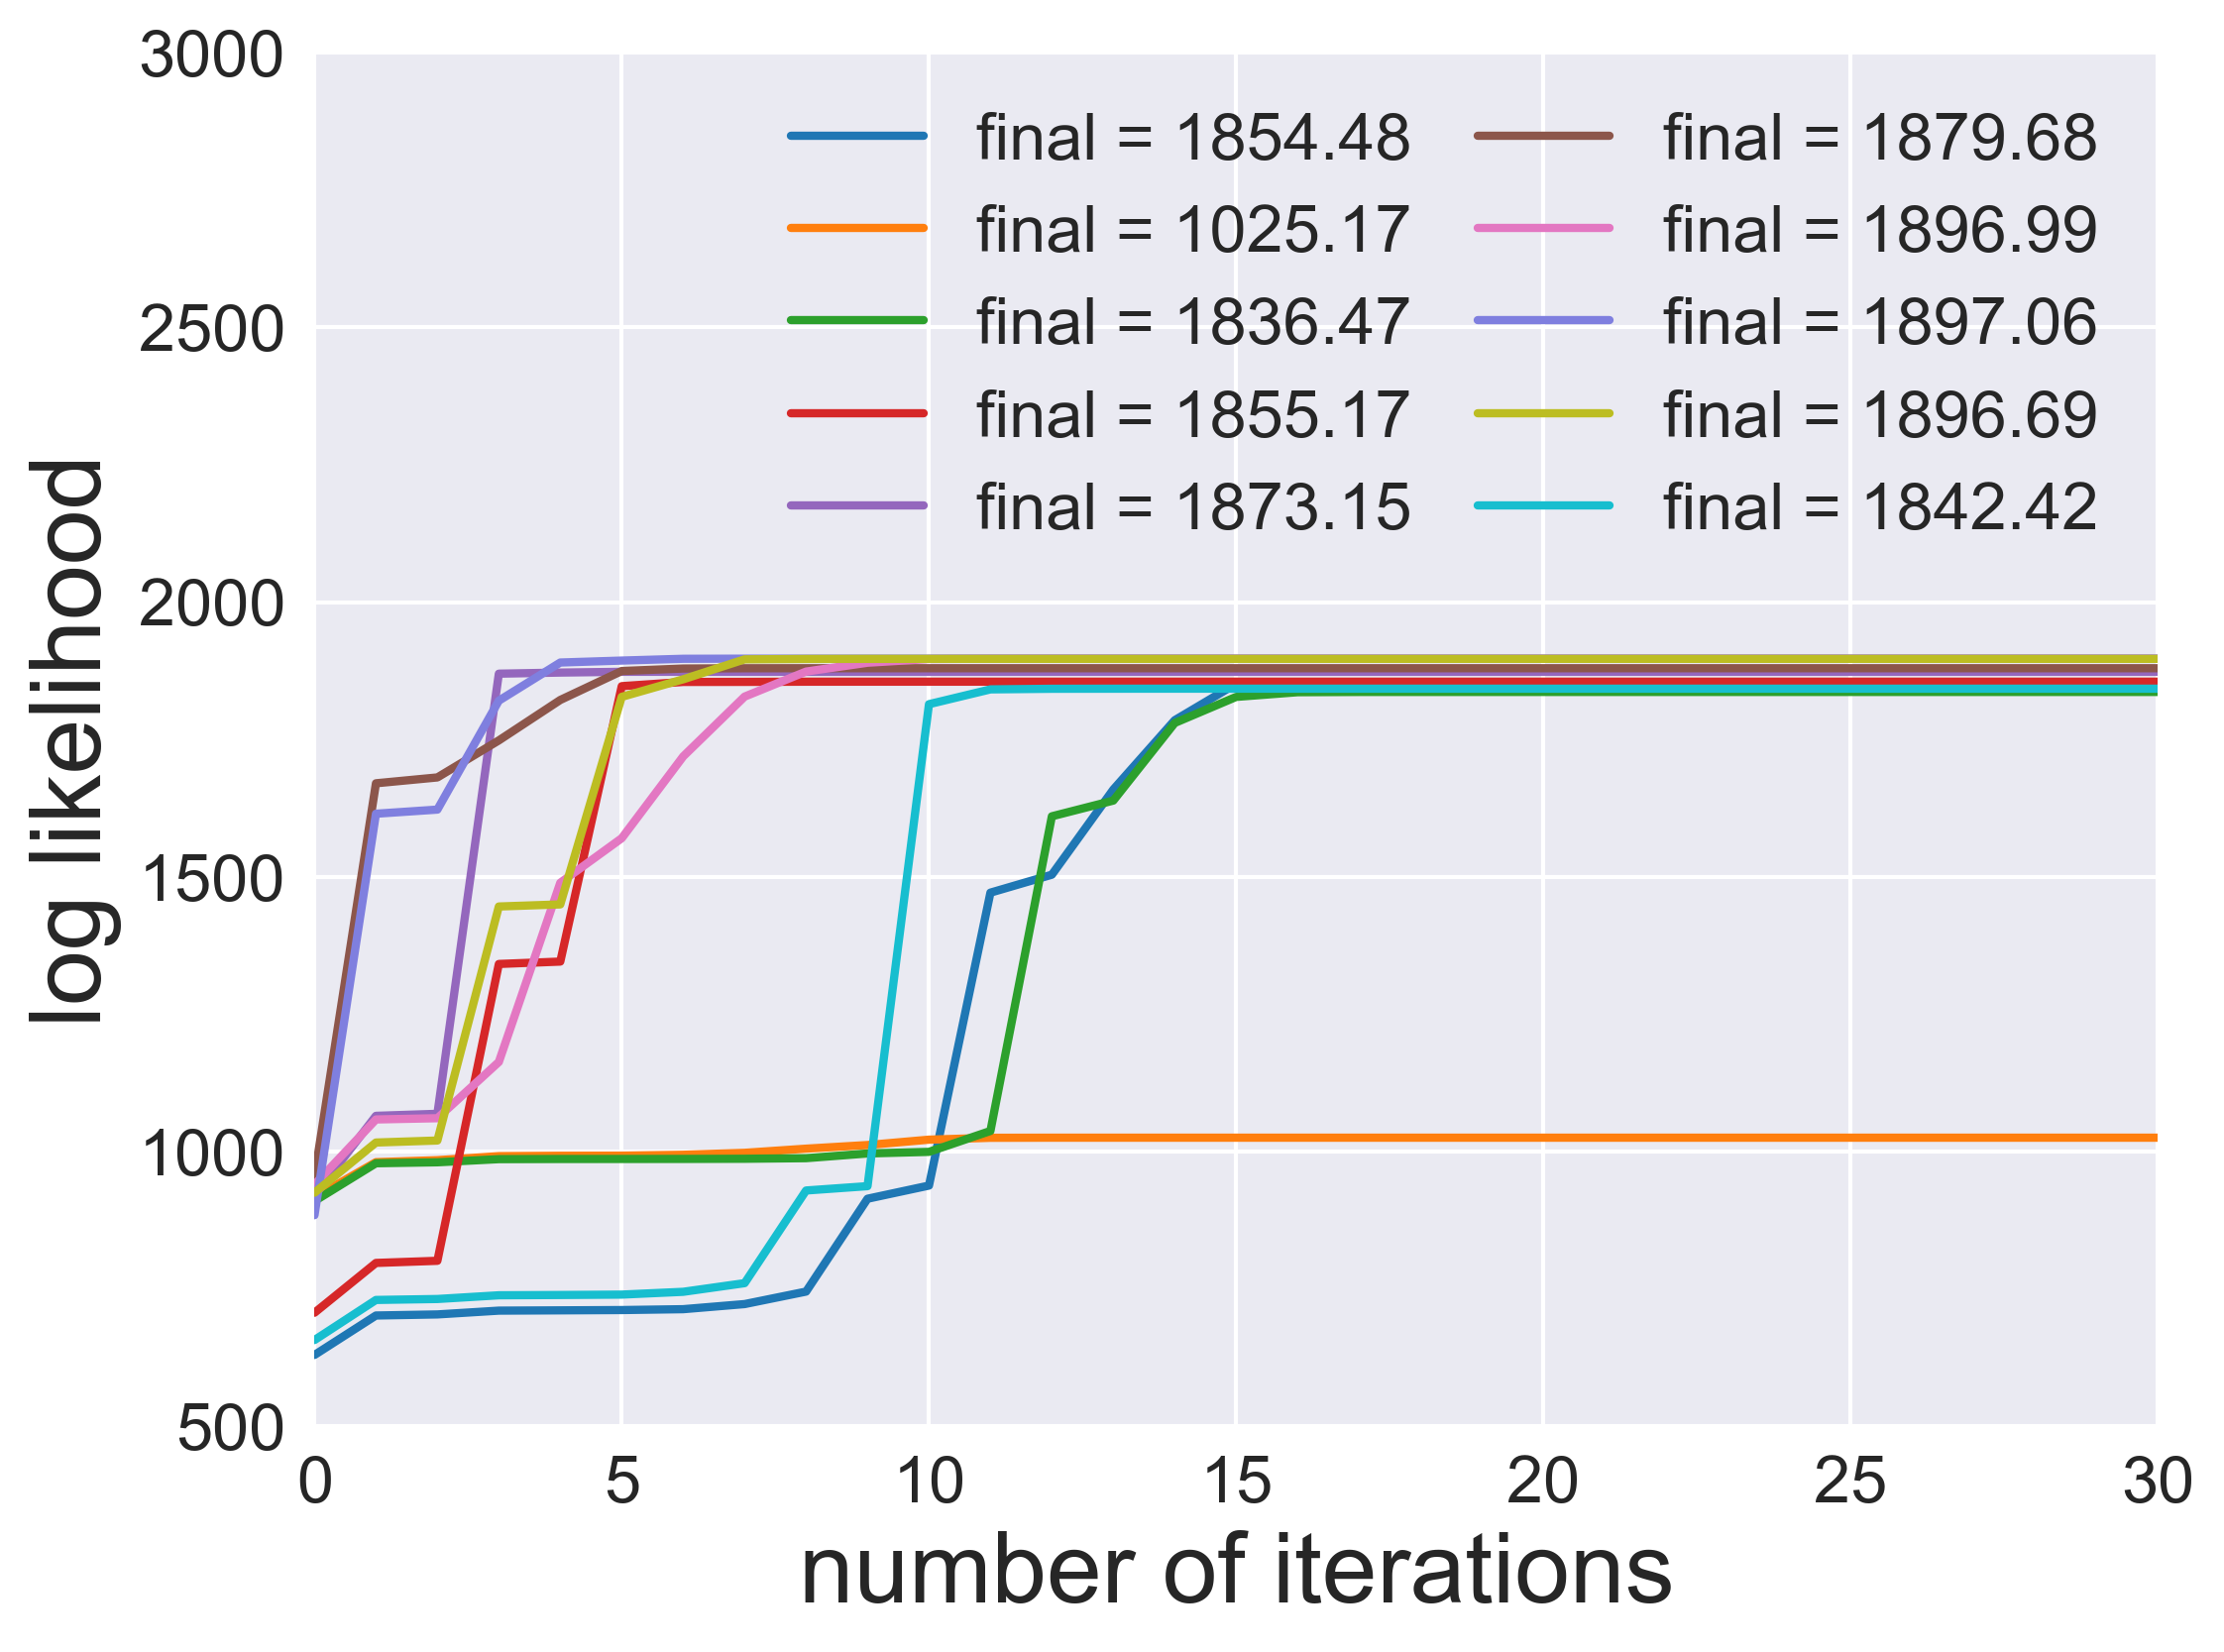

In [ ]:
"""
Display results
"""

#from google.colab import files

#Display results

print('velocity estimate = {:.4f} +/- {:.4f}'.format(np.mean(lb_save[:,0,-1]),np.std(lb_save[:,0,-1])))
print('velocity relative error = {:.2e} +/- {:.2e}'.format(np.mean(np.abs(lb_save[:,0,-1]-v)/v),np.std(np.abs(lb_save[:,0,-1]-v)/v)))
print('noise standard deviation estimate = {:.4f} +/- {:.4f}'.format(np.mean(np.abs(lb_save[:,1,-1])),np.std(np.abs(lb_save[:,1,-1]))))
print('noise standard deviation relative error = {:.2e} +/- {:.2e}'.format(np.mean(np.abs(np.abs(lb_save[:,1,-1])-eps)/eps),np.std(np.abs(np.abs(lb_save[:,0,-1])-eps)/eps)))

colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7fdf','#bcbd22','#17becf']

# plot the evolution of vhat
plt.style.use('seaborn-v0_8')
fig=plt.figure(figsize=(8,6),dpi=300)
plt.xlabel('number of iterations',size=24)
plt.ylabel('velocity estimate',size=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.hlines(v,0,maxiter,colors='black',linestyles='dashed',lw=2,label='exact = {:.0f}'.format(v))
for r in range(M):
    plt.plot(np.arange(maxiter),lb_save[r,0,],color=colors[r % 10],lw=2,label='final= {:.4f}'.format(lb_save[r,0,-1]))
plt.legend(fontsize=16,facecolor='white',ncol=2,columnspacing=1)
plt.xlim(0,30)
plt.ylim(0,20)
plt.show()
fig.savefig('Fig-advectionGP_inverse_v3.png',bbox_inches="tight",facecolor="white")
#files.download('Fig-advectionGP_inverse_v.png')

# plot the evolution of the likelihood
plt.style.use('seaborn-v0_8')
fig=plt.figure(figsize=(8,6),dpi=300)
plt.xlabel('number of iterations',size=24)
plt.ylabel('log likelihood',size=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
xsp = np.linspace(0,maxiter-1,300)
for r in range(M):
    plt.plot(np.arange(maxiter),lik[r,],color=colors[r % 10],lw=2,label='final = {:.2f}'.format(lik[r,-1]))
plt.legend(fontsize=16,facecolor='white',ncol=2,columnspacing=1)
plt.xlim(0,30)
plt.ylim(500,3000)
plt.show()
fig.savefig('Fig-advectionGP_inverse_l3.png',bbox_inches="tight",facecolor="white")
#files.download('Fig-advectionGP_inverse_l.png')

(a) Modify the code above to plot the evolution of the velocity
estimate and the log-likelihood value, over 10 independent runs, for Nx = 16, 32, 64
uniformly-distributed spatial sensors, and the same 8 temporal snapshots as in the original
code. What do you observe?

(b) Generate a barplot of the relative error of the parameter estimate at the end of training,
showing the mean and standard error bar over 10 independent runs, for Nx = 16, 32, 64
spatial sensors, and the same 8 temporal snapshots as in the original code, and varying
the true velocity v = 20, 30, 40, 50, 60. Group the results in a single bar plot, with the
velocity in the x axis, the relative error in the y axis, and using di↵erent bar colors to
indicate the number of sensors. Add the standard deviation error bars to the plot as well.
Explain in detail what the e↵ect of the number of sensors and the true velocity is on the
accuracy of the results. In particular, compare the results to the forward problem results
in the previous section for large values of the velocity.